In [568]:
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pydse.arma import minic, ARMA
from pydse.utils import make_lag_arr
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
%matplotlib inline

In [569]:
df_preCovid_train = pd.read_pickle("../Data/Subway_Data/preCovid_stdized_train.pkl")
df_preCovid_test = pd.read_pickle("../Data/Subway_Data/preCovid_stdized_test.pkl")
df_preCovid_full = pd.concat([df_preCovid_train, df_preCovid_test])
df_postCovid = pd.read_pickle("../Data/Subway_Data/postCovid_stdized.pkl")
df_all =  pd.concat([df_preCovid_full, df_postCovid])

In [570]:
df_preCovid_train.head(2)

,entries,entries_scaled
date,,
2015-01-03,2682846.0,-1.703944
2015-01-04,2481666.0,-1.877997


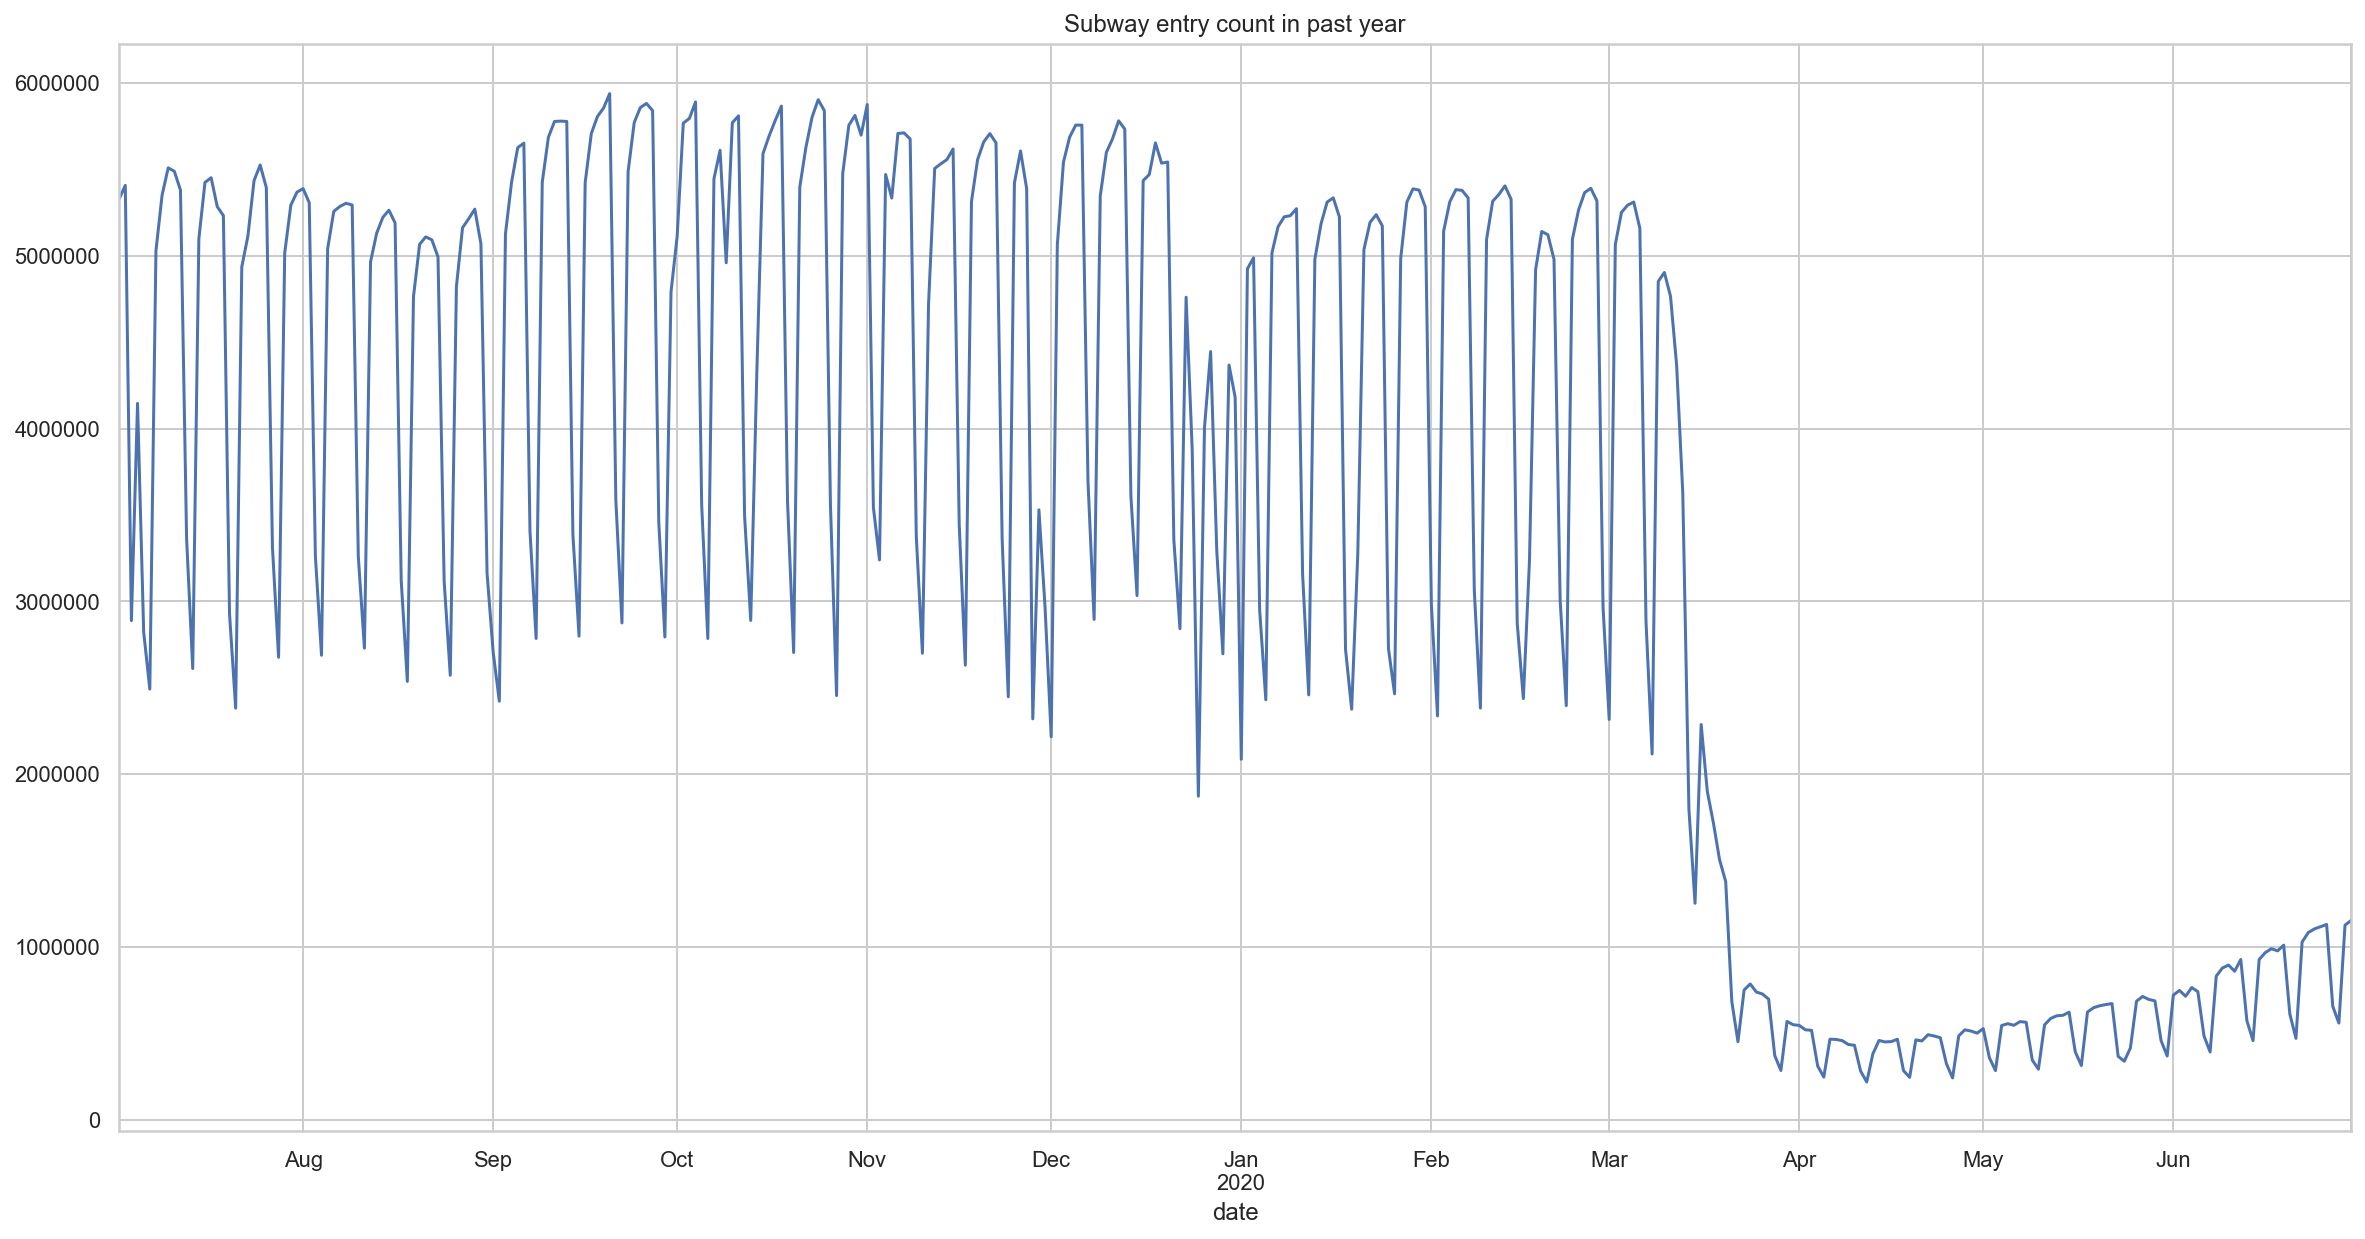

In [571]:
plt.figure(figsize=(20,10))
plt.title("Subway entry count in past year")
df_all["entries"][-365:].plot()
plt.show()

## Find gaps in timeseries

In [572]:
def find_gaps(df):
    df.reset_index(inplace=True)
    df["timediff"] = (df['date'] - df['date'].shift(1)) / np.timedelta64(1, 'D')
    print(df['timediff'].value_counts())
    df.set_index('date', inplace=True)
    
    return df

In [573]:
df_all = find_gaps(df_all)

# only have 1 day interval so good

1.0    2005
Name: timediff, dtype: int64


## Add columns for year, month, day, weekday

In [574]:
def add_date_col(df):
    df['year'] = df.index.map(lambda x: x.year)
    df['month'] = df.index.map(lambda x: x.month)
    df['day'] = df.index.map(lambda x: x.day)
    df['weekday'] = df.index.map(lambda x:x.weekday())
    df.reset_index(inplace=True)
    
    df['timeindex'] = (df['date'] - pd.Timestamp('2015-01-03')) / np.timedelta64(1, 'D')
    
    print(df.head(2))
    
    return df

In [575]:
df_all = add_date_col(df_all)

        date    entries  entries_scaled  timediff  year  month  day  weekday  \
0 2015-01-03  2682846.0       -1.703944       NaN  2015      1    3        5   
1 2015-01-04  2481666.0       -1.877997       1.0  2015      1    4        6   

   timeindex  
0        0.0  
1        1.0  


## Data Split

In [576]:
df_preCovid_train = df_all[df_all.date < '2019-11-01']
df_tmp = df_all[~(df_all.date < '2019-11-01')]
df_preCovid_test = df_tmp[df_tmp.date < '2020-03-01']
df_postCovid = df_tmp[~(df_tmp.date < '2020-03-01')]
df_preCovid_all = df_all[df_all.date < '2020-03-01']

## Arima model
- not really good for non-stationary
- remove seasonality
- remove linear trend

### remove linear trend
- using only **df_preCovid_train**

In [577]:
def remove_lin_trend(df_train, df_test, df_full):
    
    X_train = np.c_[df_train['timeindex']]
    y_train = df_train['entries']
    
    X_full = np.c_[df_full['timeindex']]
    print(len(X_train), len(y_train), len(X_full))
    
    linreg = linear_model.LinearRegression()
    linreg.fit(X_train, y_train)    

    df_full['trend'] = linreg.predict(X_full)
    
    df_full.set_index('date', inplace=True)
    print(df_full.head(2))
    
    plt.figure(figsize=(20,10))
    plt.title("Subway entry count and linear trend")
    df_full["entries"][:730].plot()
    df_full["trend"][:730].plot()

    plt.legend(loc=2)
    plt.show()
    
    #detrend
    plt.figure(figsize=(20,10))
    df_full['entries_detrended'] = df_full['entries'] / df_full['trend']
    df_full['entries_detrended'][:730].plot()
    plt.show()
    
    return df_full

1763 1763 1884
              entries  entries_scaled  timediff  year  month  day  weekday  \
date                                                                         
2015-01-03  2682846.0       -1.703944       NaN  2015      1    3        5   
2015-01-04  2481666.0       -1.877997       1.0  2015      1    4        6   

            timeindex         trend  
date                                 
2015-01-03        0.0  4.687625e+06  
2015-01-04        1.0  4.687585e+06  


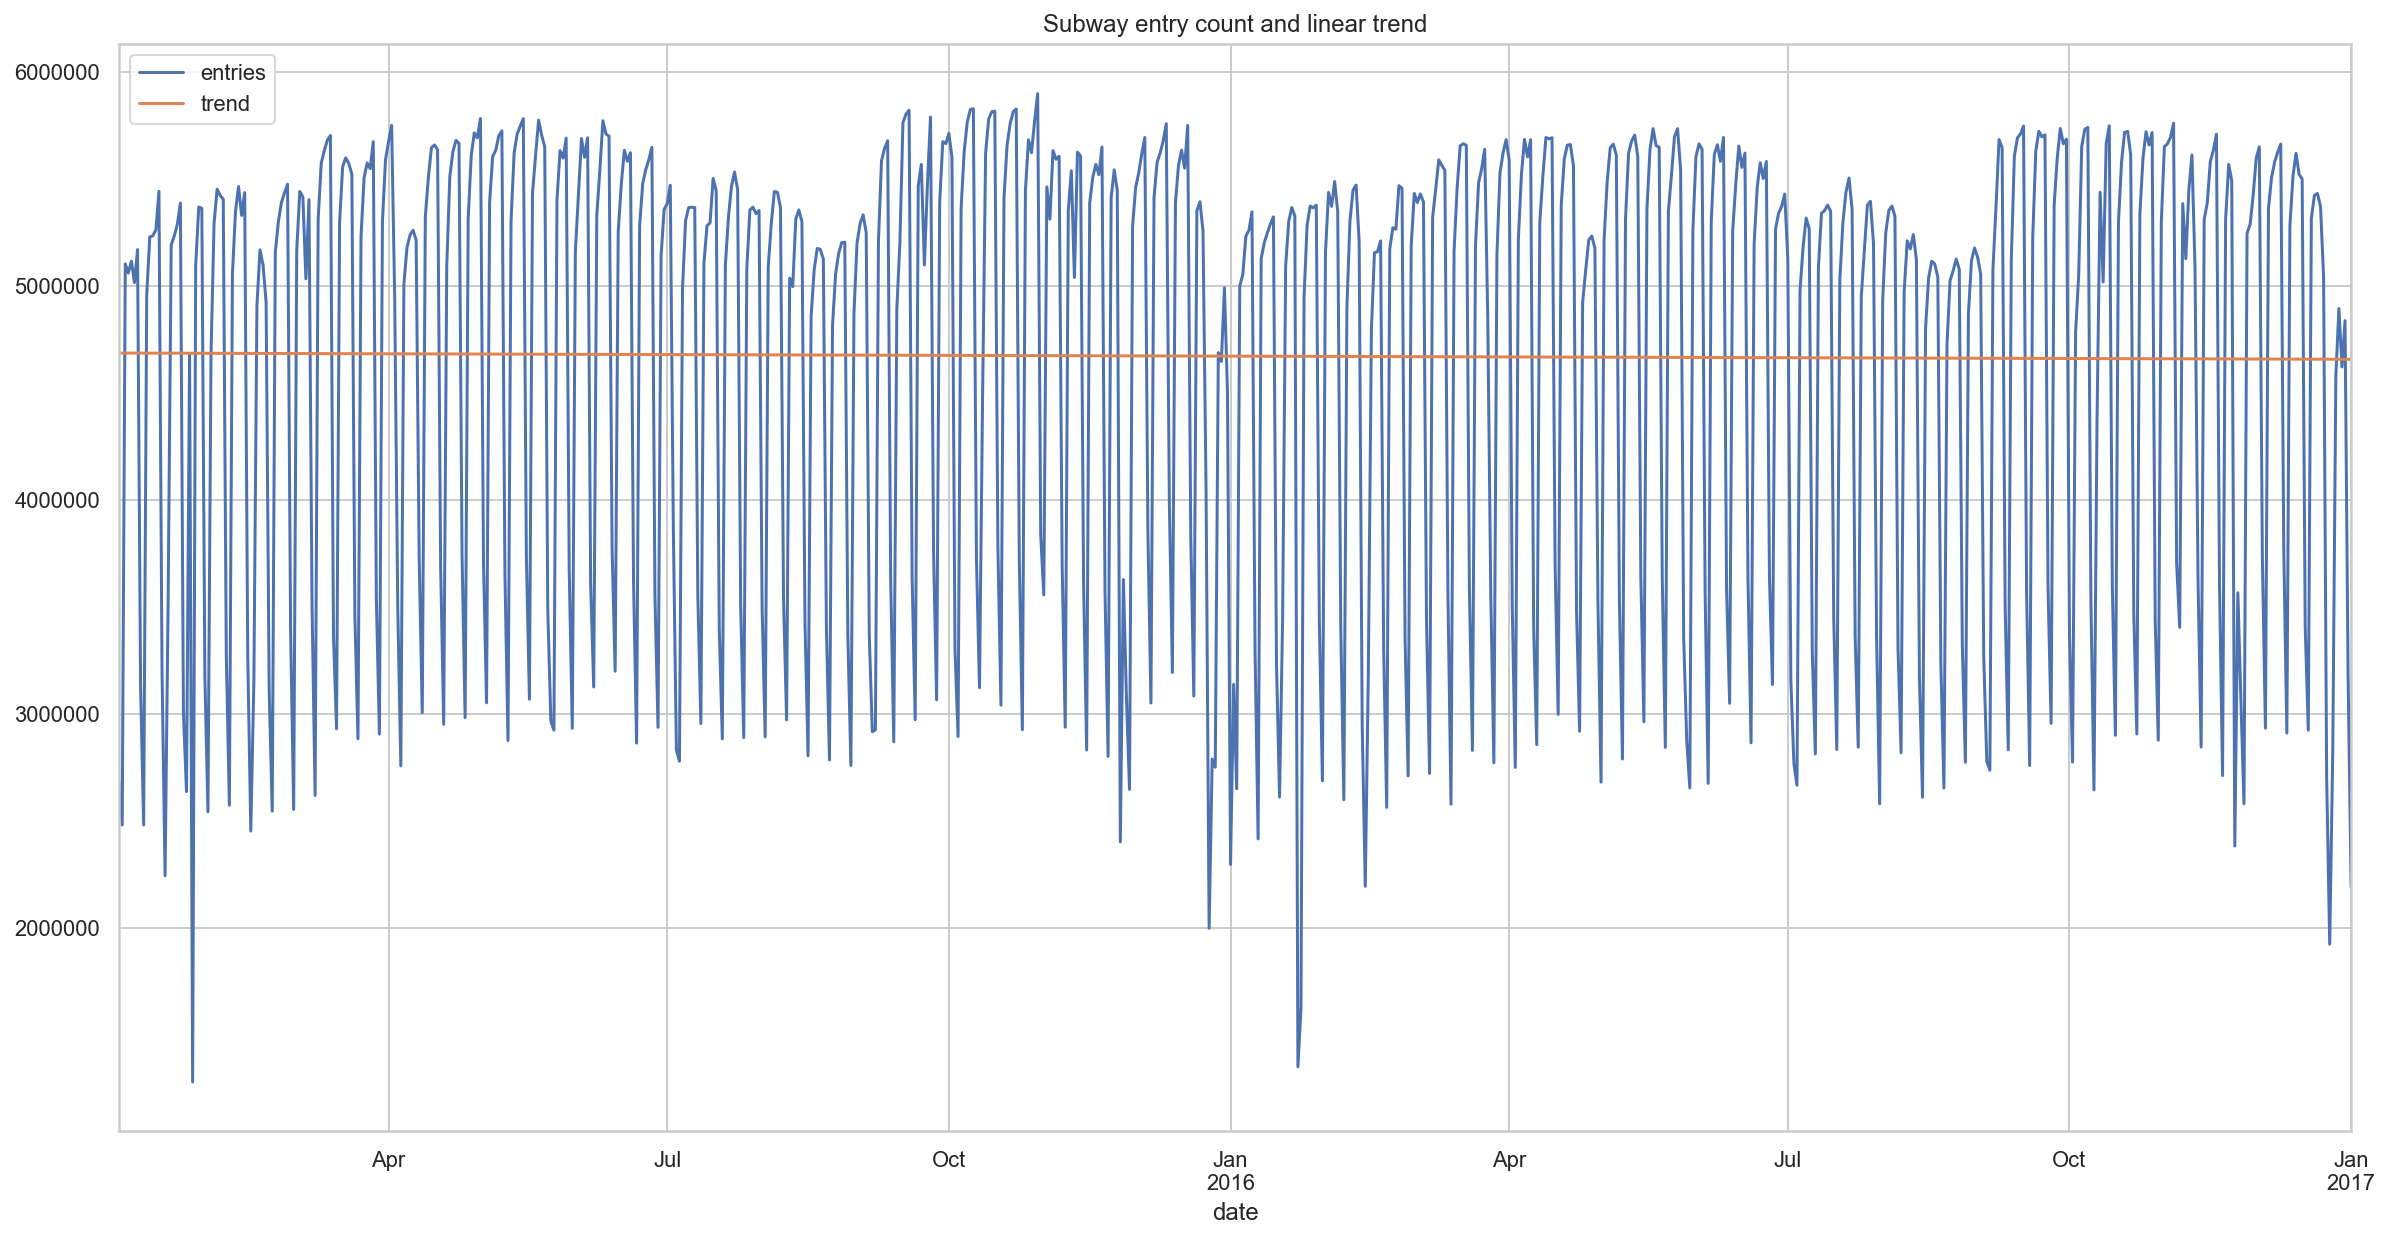

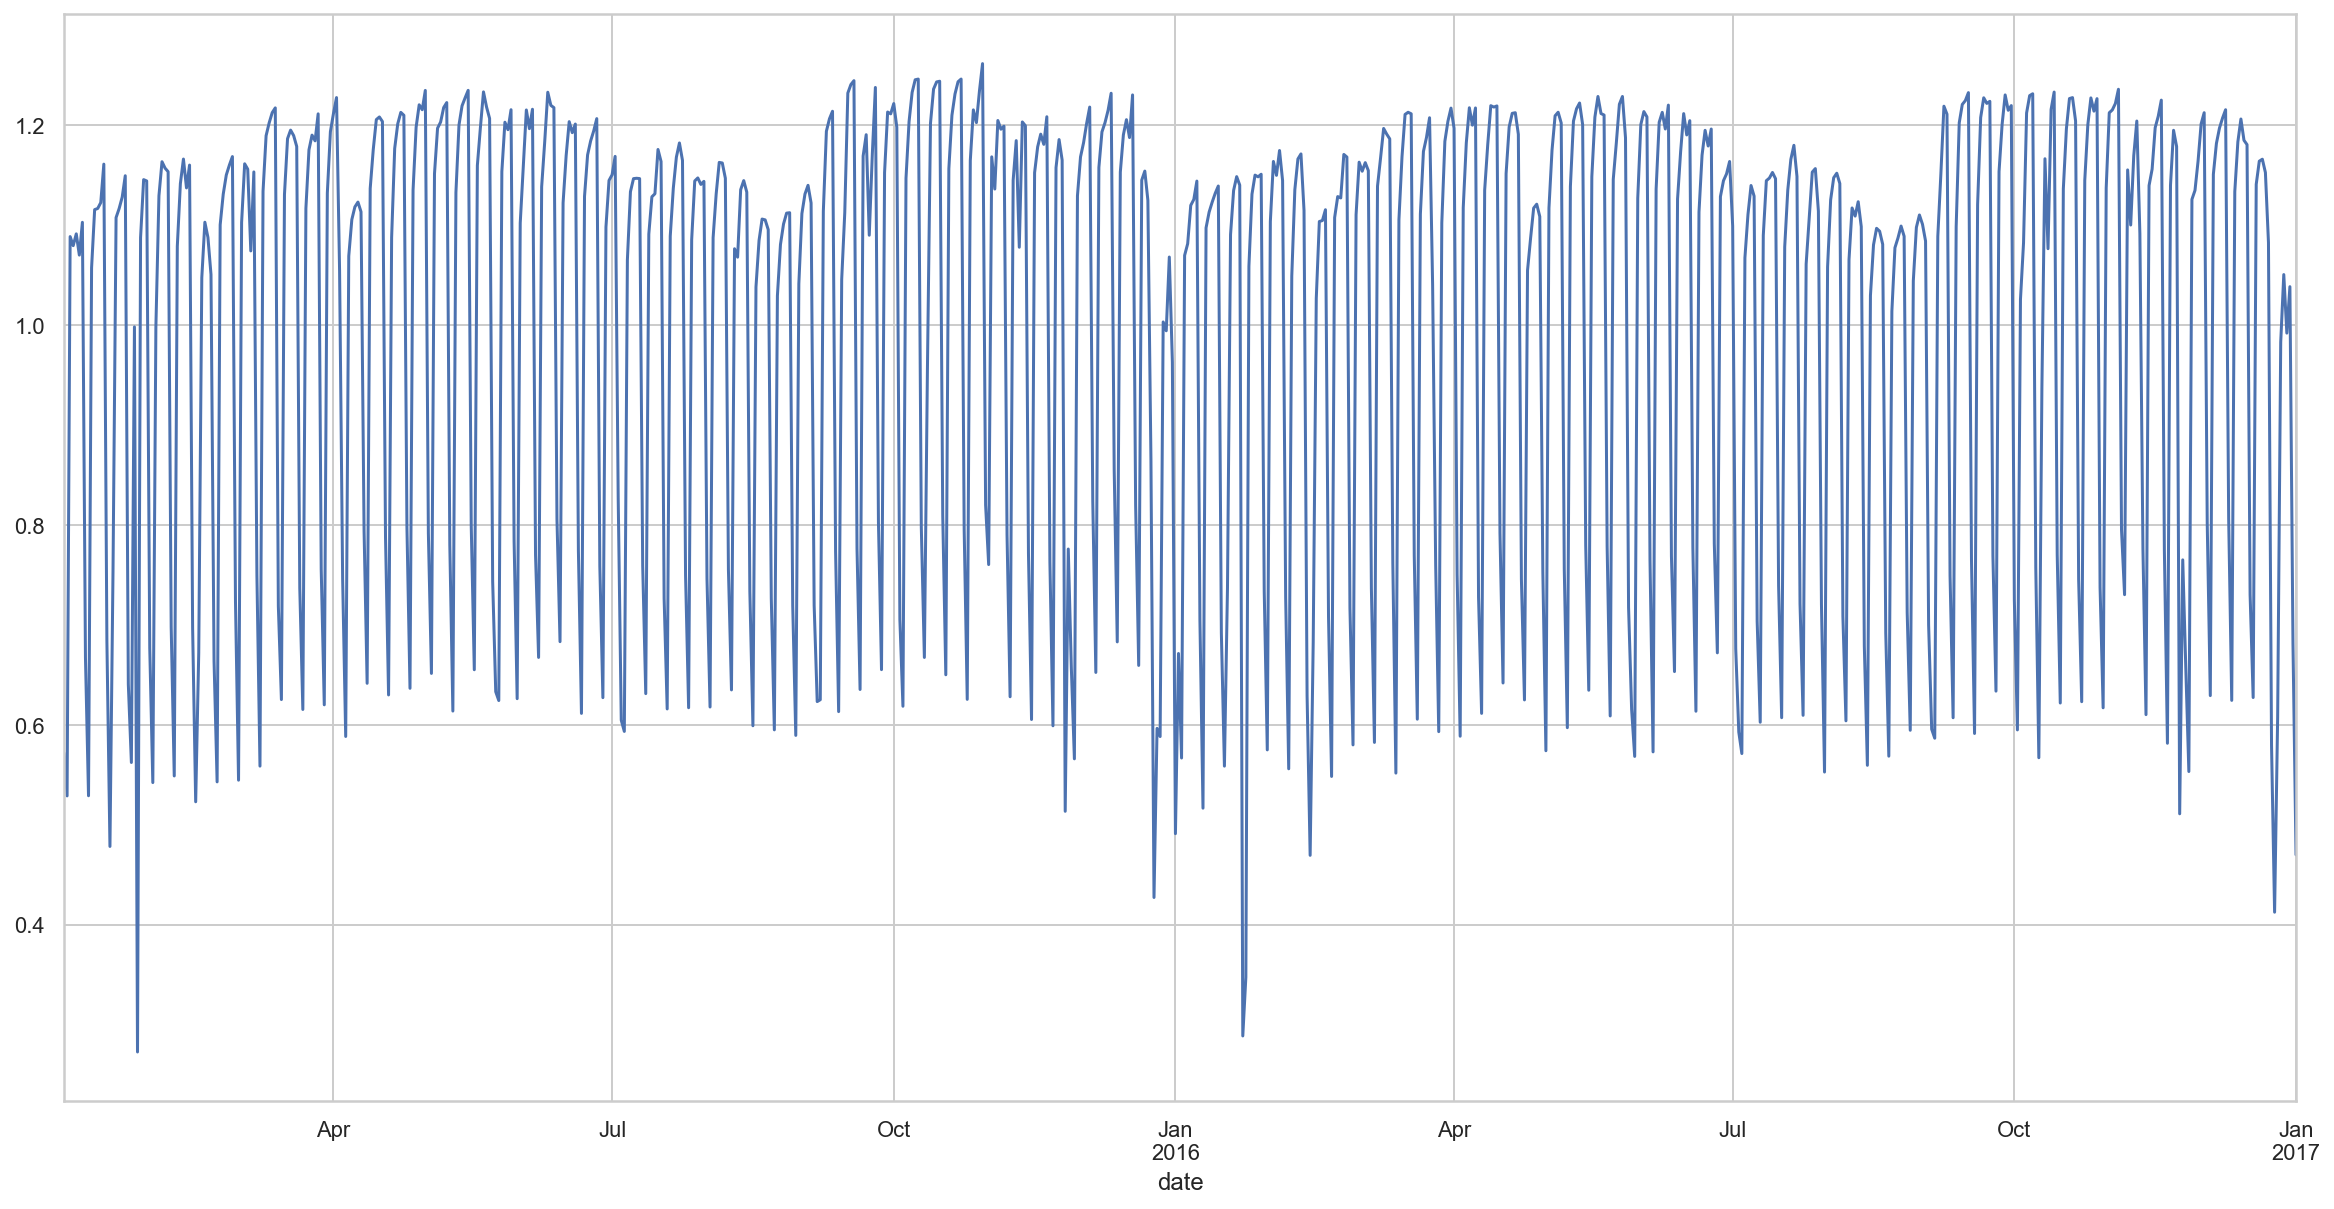

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended
date,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413


In [578]:
df_preCovid_all = remove_lin_trend(df_preCovid_train, df_preCovid_test, df_preCovid_all)
df_preCovid_all.head(2)

### Factor model

In [579]:
def remove_weekday_profile(row):
    return row['entries_detrended'] / weekday_factor[row['weekday']] 
def remove_month_profile(row):
    return row['entries_detrended_deweekdayed'] / month_factor[row['month']]

pred = f(trend) * f(weekday) * f(month)

In [580]:
def plot_factor_model(df):
    weekday_factor = df.groupby('weekday')['entries_detrended'].mean().to_dict()
    df['entries_detrended_deweekdayed']  = df.apply(remove_weekday_profile, axis=1)
    month_factor = df.groupby('month')['entries_detrended'].mean().to_dict()
    df['entries_detrended_deweekdayed_demonthed']  = df.apply(remove_month_profile, axis=1)
    
    #plot factored-out data
    plt.figure(figsize=(20,10))
    df['entries_detrended_deweekdayed_demonthed'][:730].plot()
    plt.show()
    
    return df

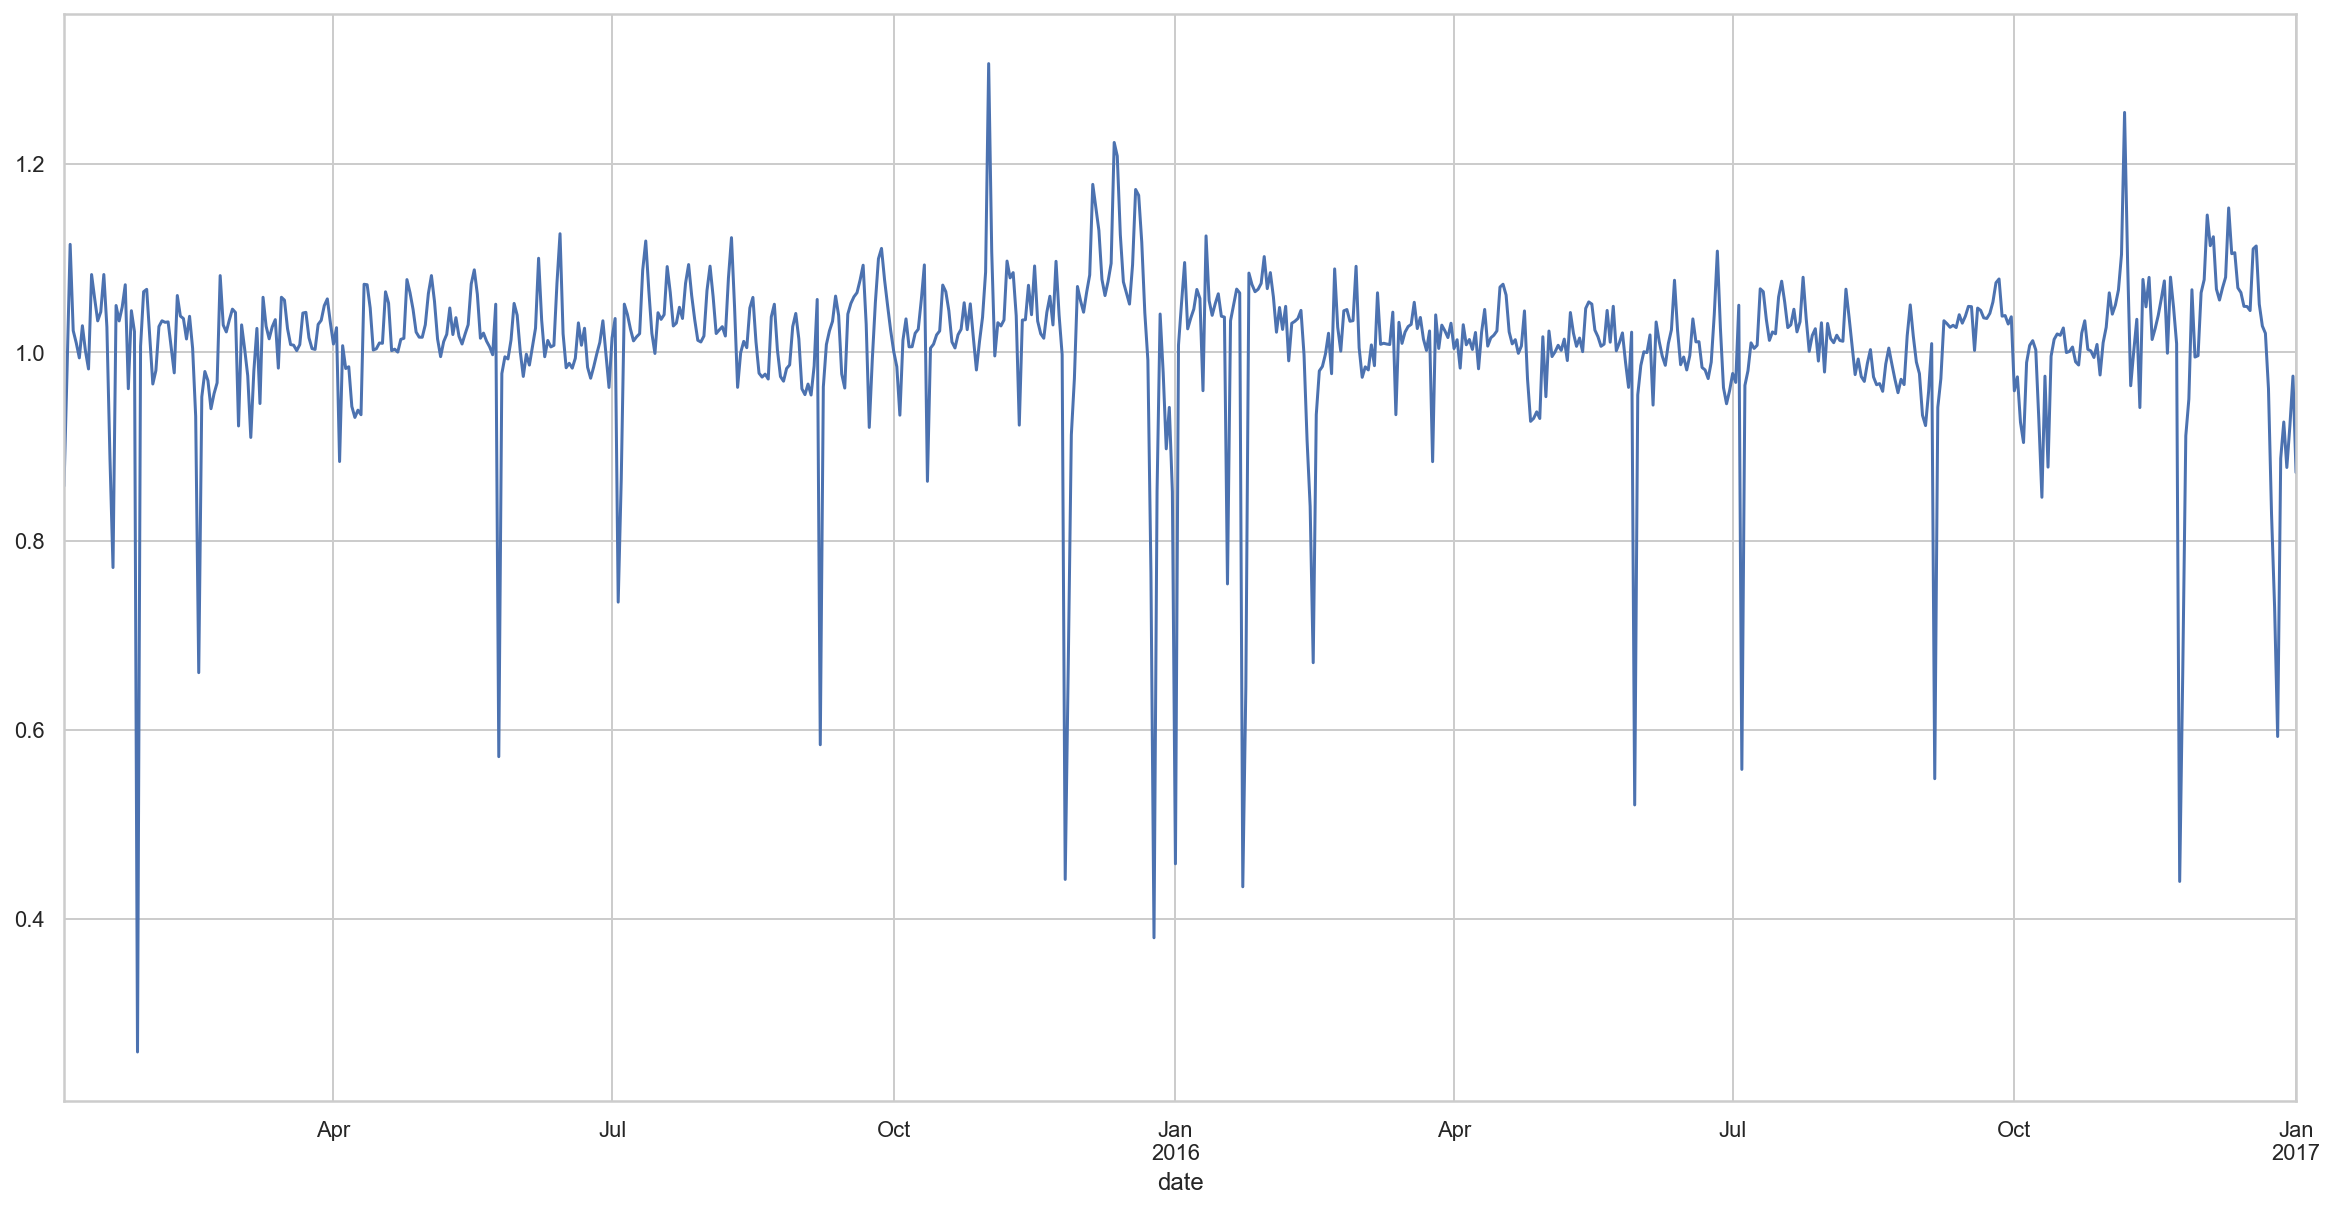

In [581]:
df_preCovid_all = plot_factor_model(df_preCovid_all)

### Data Split

In [582]:
df_preCovid_train = df_preCovid_all[df_preCovid_all.index < '2019-11-01']
df_preCovid_test = df_preCovid_all[~(df_preCovid_all.index < '2019-11-01')]

In [583]:
def factor_model(row):
    return row['trend'] * weekday_factor[row['weekday']] * month_factor[row['month']]

In [584]:
df_preCovid_train['factor_model'] = df_preCovid_train.apply(factor_model, axis=1)
df_preCovid_test['factor_model'] = df_preCovid_test.apply(factor_model, axis=1)

In [585]:
df_preCovid_train.head()

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model
date,,,,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325,0.794806,0.858439,3.125261e+06
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413,0.909391,0.982199,2.526643e+06
2015-01-05,5104111.0,0.390841,1.0,2015,1,5,0,2.0,4.687545e+06,1.088867,1.031871,1.114485,4.579795e+06
2015-01-06,5061648.0,0.354104,1.0,2015,1,6,1,3.0,4.687505e+06,1.079817,0.947288,1.023130,4.947220e+06
2015-01-07,5116883.0,0.401891,1.0,2015,1,7,2,4.0,4.687465e+06,1.091610,0.935098,1.009963,5.066405e+06


### standardize the data

In [586]:
scaler = StandardScaler()
scaler.fit(df_preCovid_train['factor_model'].values.reshape(-1,1))
print(scaler.mean_)
df_preCovid_train['pred_scaled'] = scaler.transform(df_preCovid_train['factor_model'].values.reshape(-1,1))
df_preCovid_test['pred_scaled'] = scaler.transform(df_preCovid_test['factor_model'].values.reshape(-1,1)) 

[4643363.59271957]


In [587]:
df_preCovid_train.head(2)

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model,pred_scaled
date,,,,,,,,,,,,,,
2015-01-03,2682846.0,-1.703944,NaN,2015,1,3,5,0.0,4.687625e+06,0.572325,0.794806,0.858439,3.125261e+06,-1.427757
2015-01-04,2481666.0,-1.877997,1.0,2015,1,4,6,1.0,4.687585e+06,0.529413,0.909391,0.982199,2.526643e+06,-1.990750


### Evaluate

In [588]:
def mse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = mean_squared_error(y_actual, y_predicted)
    if print_val:
        print('MSE: {:,.4f}'.format(err))
    else:
        return err

def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Ridership Count', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xticks(actual.index.date[::7], 
#                actual.index.day[::7])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)


In [589]:
def evaluate(pred, truth):
    mae = mean_squared_error(truth, pred)
    plt.figure(figsize=(20,10))
    plt.plot(pred, label='prediction')
    plt.plot(truth, label='truth')
    plt.title("MSE: {:.2f}".format(mae))
    plt.legend()
    plt.show()
    return mae

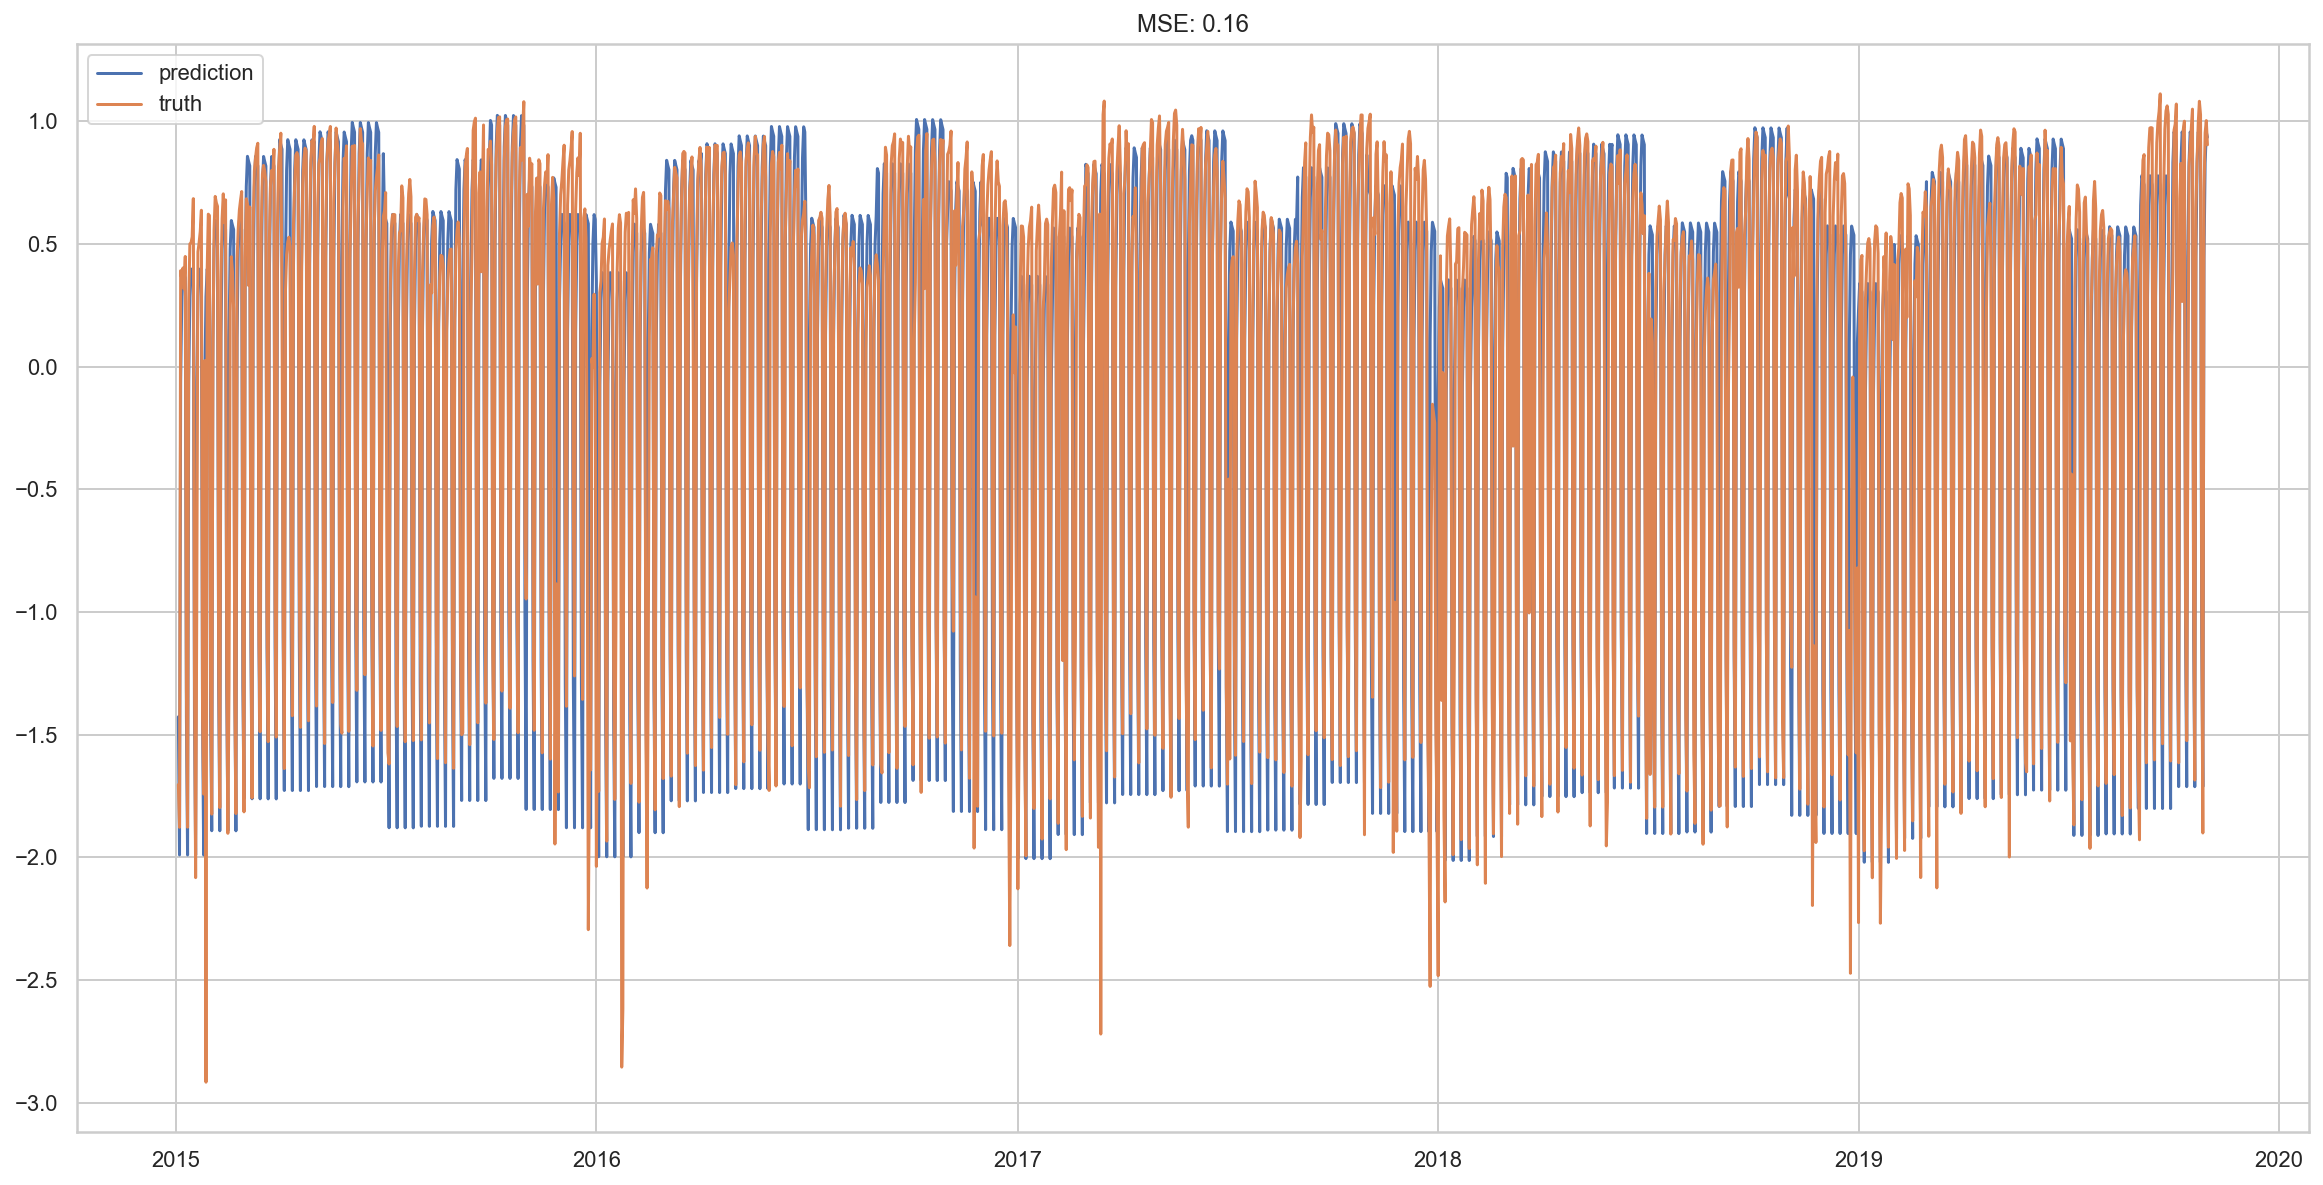

0.15914986906198034

In [590]:
evaluate(df_preCovid_train['pred_scaled'], df_preCovid_train['entries_scaled'])

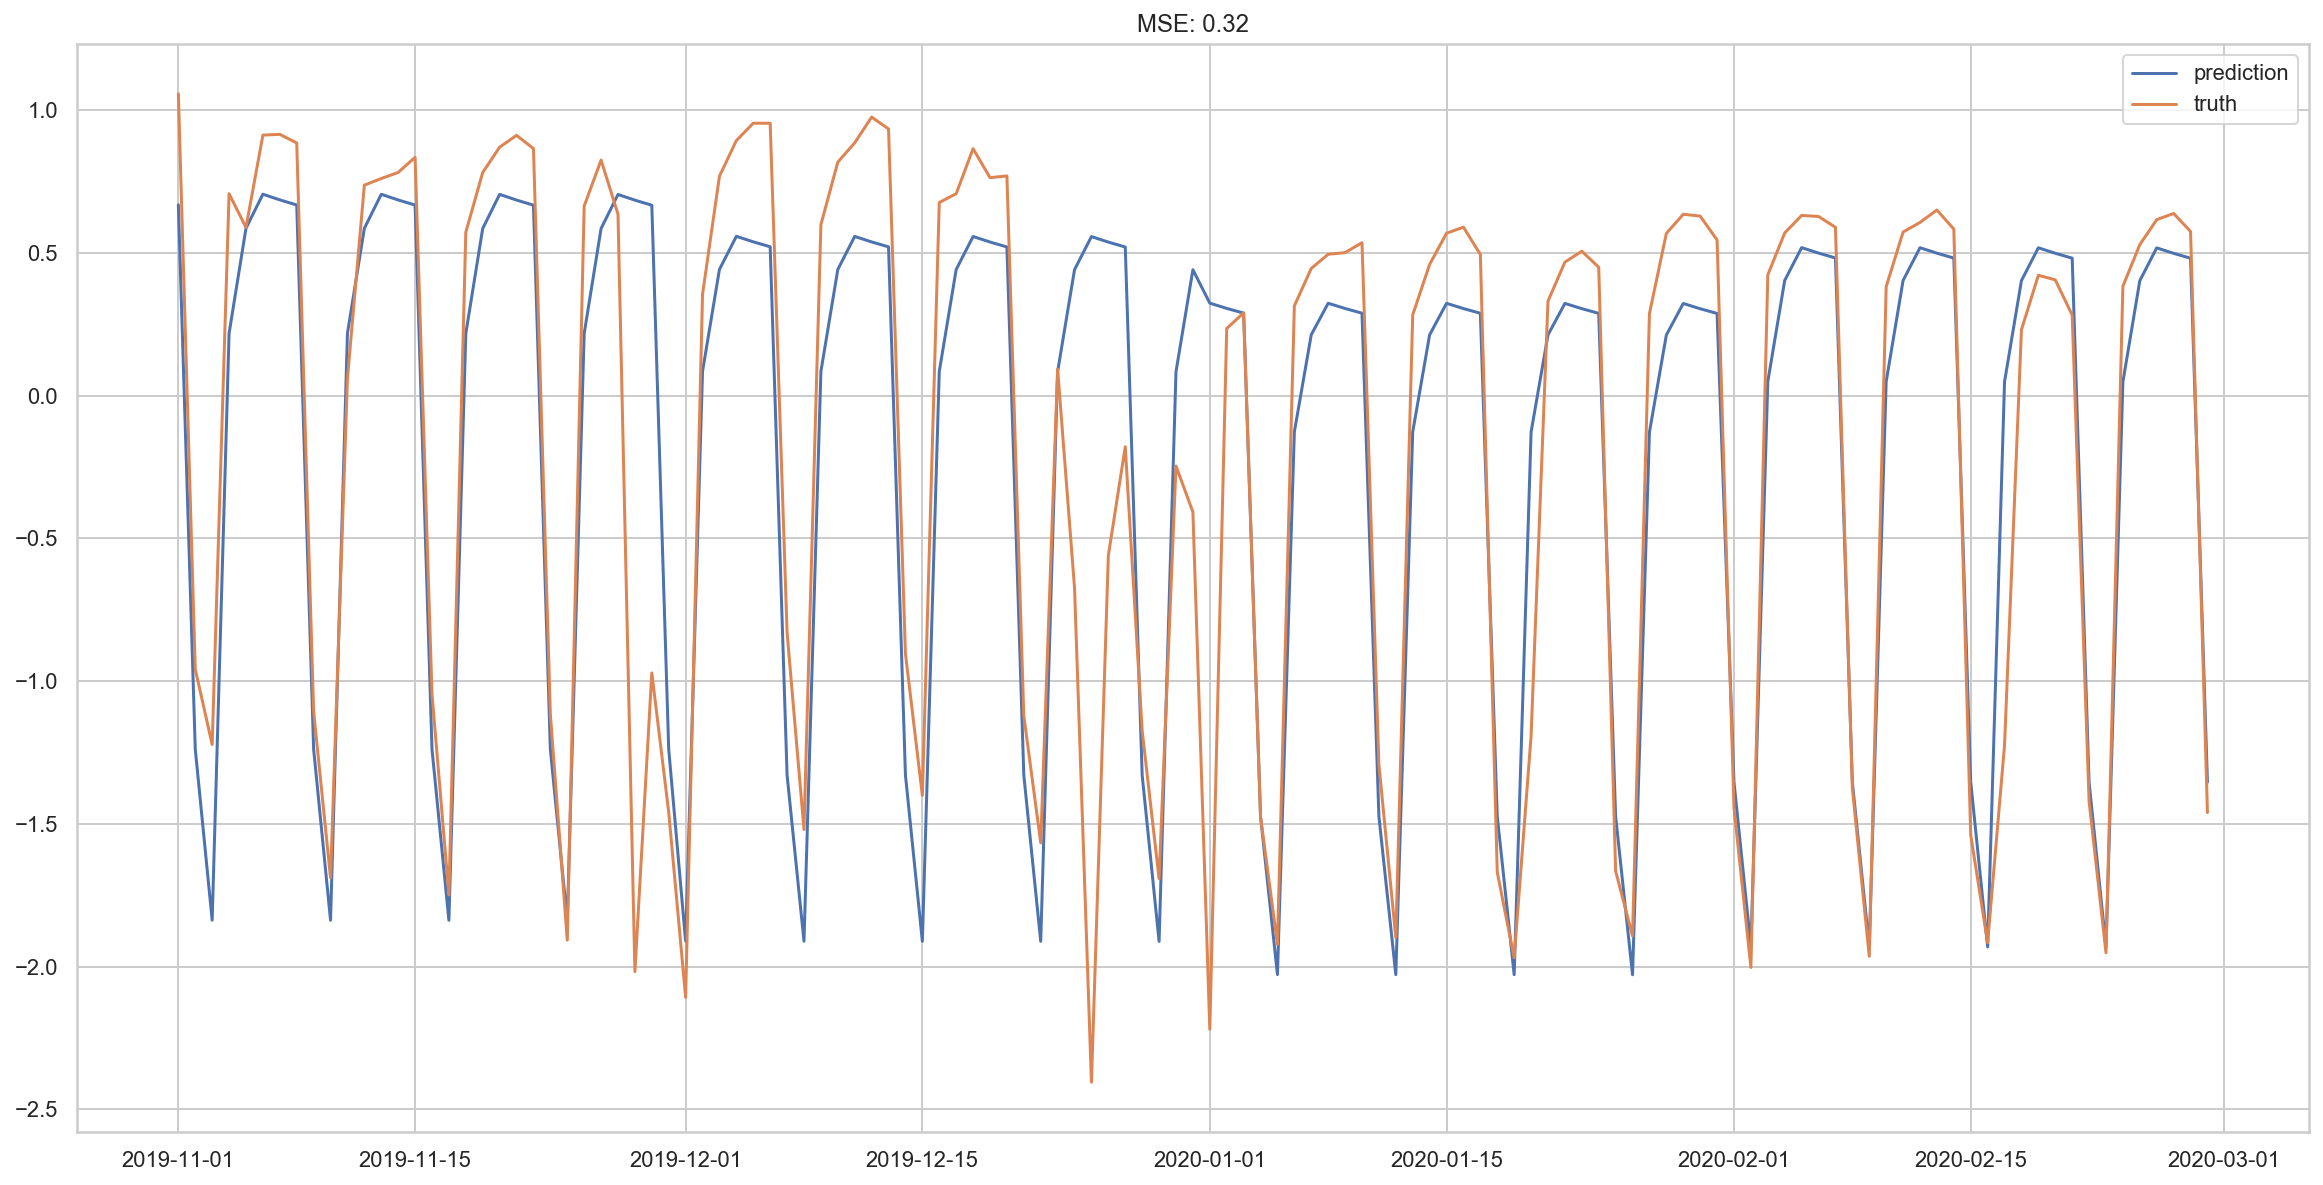

0.3233357127162111

In [591]:
evaluate(df_preCovid_test['pred_scaled'], df_preCovid_test['entries_scaled'])

## ARMA on residuals
- entries with detrended, deweekdayed, demonthed

In [592]:
df_preCovid_residual_train = df_preCovid_train[['entries_detrended_deweekdayed_demonthed']]
df_preCovid_residual_test = df_preCovid_test[['entries_detrended_deweekdayed_demonthed']]

In [593]:
df_preCovid_residual_train.head(2)

,entries_detrended_deweekdayed_demonthed
date,
2015-01-03,0.858439
2015-01-04,0.982199


In [594]:
#standardize residual
scaler = StandardScaler()
scaler.fit(df_preCovid_residual_train)
print(scaler.mean_)
df_preCovid_residual_train['residual_scaled'] = scaler.transform(df_preCovid_residual_train)
df_preCovid_residual_test['residual_scaled'] = scaler.transform(df_preCovid_residual_test) 

[1.0019623]


In [595]:
df_preCovid_residual_train.drop('entries_detrended_deweekdayed_demonthed', axis=1, inplace=True)
df_preCovid_residual_test.drop('entries_detrended_deweekdayed_demonthed', axis=1, inplace=True)

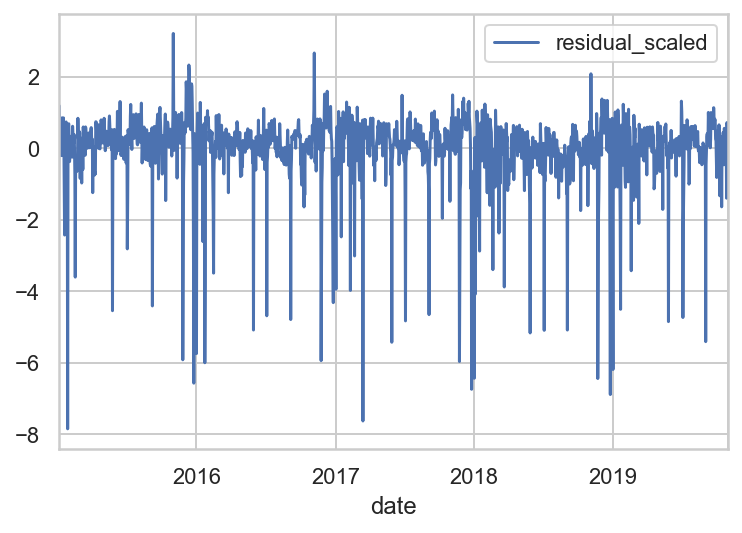

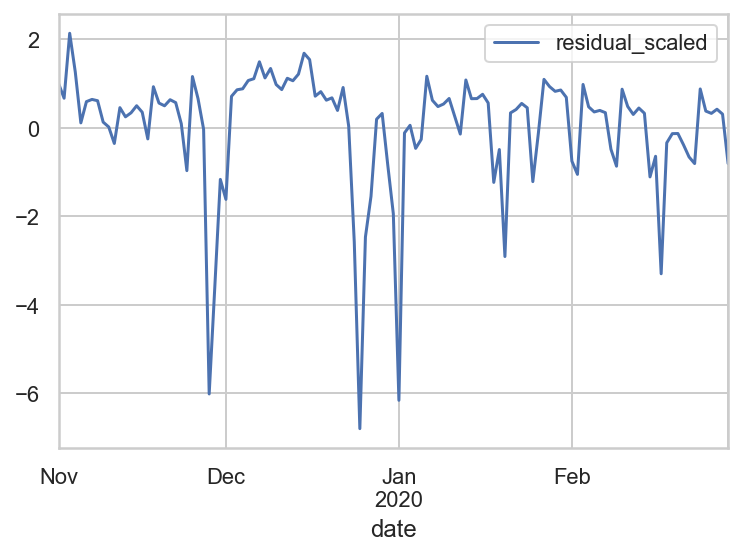

In [596]:
df_preCovid_residual_train.plot()
df_preCovid_residual_test.plot()
plt.show()

### Plot acf and pacf

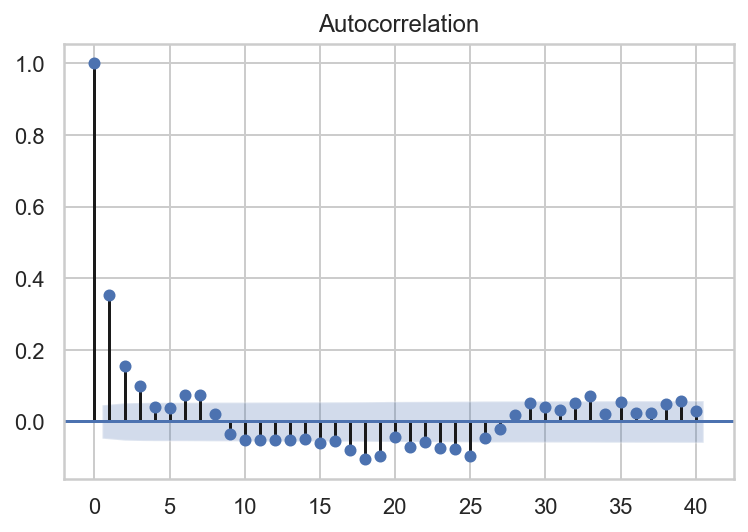

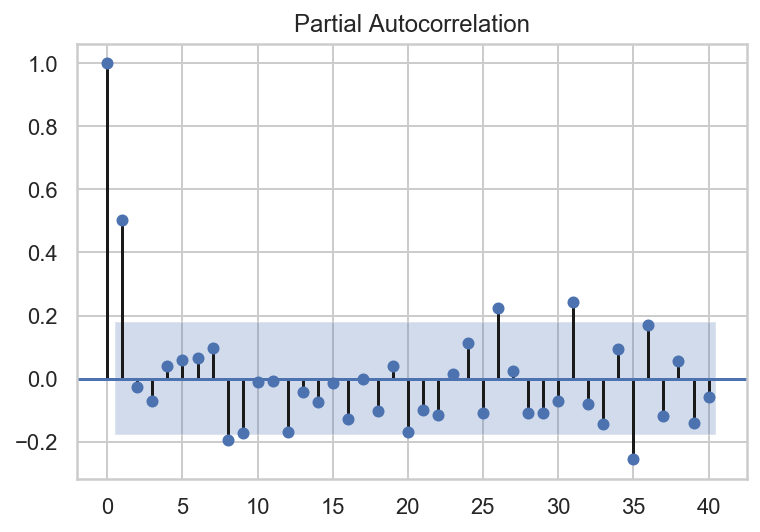

In [597]:
plot_acf(df_preCovid_residual_train, lags=40)
plt.show()

plot_pacf(df_preCovid_residual_test, lags=40)
plt.show()

### Find best AR and MA lags

In [598]:
preCovid_residual_train = df_preCovid_residual_train['residual_scaled']
preCovid_residual_train.head(2)

date
2015-01-03   -1.515937
2015-01-04   -0.208746
Name: residual_scaled, dtype: float64

In [599]:
preCovid_residual_test = df_preCovid_residual_test['residual_scaled']
preCovid_residual_test.head(2)

date
2019-11-01    1.006110
2019-11-02    0.670434
Name: residual_scaled, dtype: float64

In [600]:
# best_ar_lags, best_ma_lags = minic([1], [1, 2, 3], preCovid_residual_train, crit='AIC')
# print(best_ar_lags, best_ma_lags)

### ARMA(1,3)

In [601]:
ar_lags =(1,)
ma_lags =(3,)

In [602]:
ar_lag_arr = make_lag_arr(ar_lags)
ma_lag_arr = make_lag_arr(ar_lags)
print(ar_lag_arr)
print(ma_lag_arr)

arma = ARMA(A=ar_lag_arr, B=ma_lag_arr, rand_state=0)
arma.fix_constants()
arma.est_params(preCovid_residual_train)

(array([1.  , 0.01]), array([2, 1, 1]))
(array([1.  , 0.01]), array([2, 1, 1]))


      fun: 2382.656770050951
 hess_inv: array([[0.00418504, 0.00445527],
       [0.00445527, 0.00531953]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 69
      nit: 8
     njev: 16
   status: 0
  success: True
        x: array([-0.45338812, -0.11463443])

### Fit ARMA(1,3) Model

In [603]:
df_preCovid_residual_train['pred'] = arma.forecast(preCovid_residual_train)[:,0]
df_preCovid_residual_test['pred'] = arma.forecast(preCovid_residual_test)[:,0]

### Train MSE

MSE: 0.8738


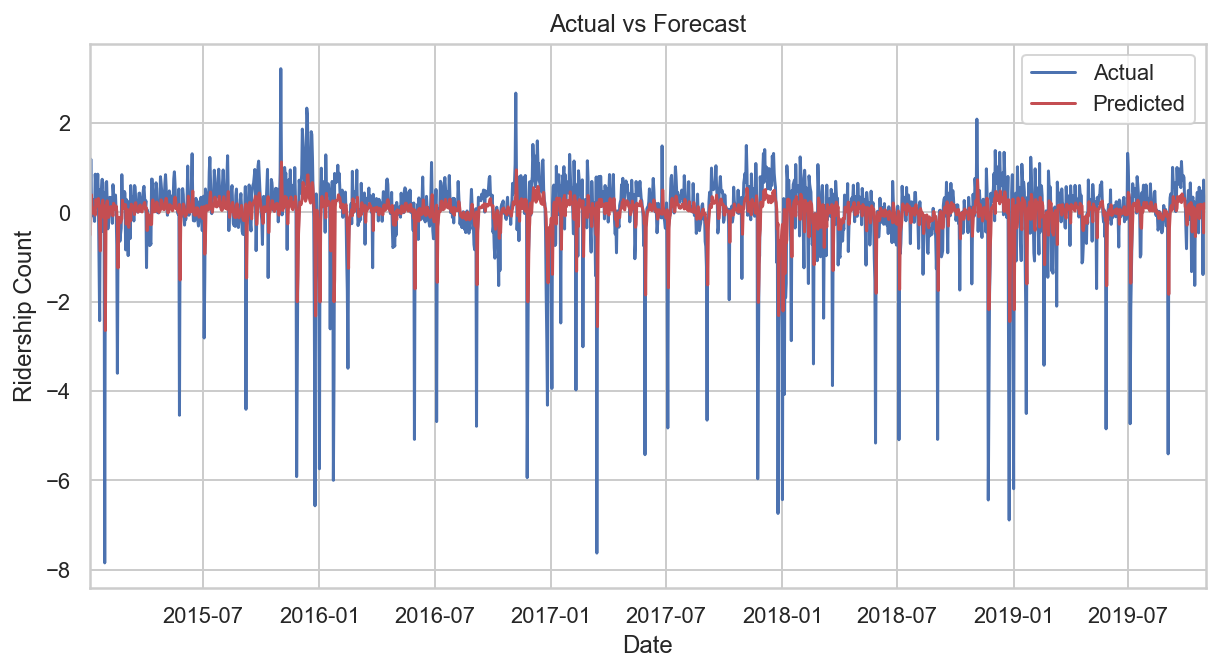

In [604]:
plot_forecast(df_preCovid_residual_train['residual_scaled'],df_preCovid_residual_train['pred'])
mse(df_preCovid_residual_train['residual_scaled'], df_preCovid_residual_train['pred'])

### Test MSE

MSE: 1.5328


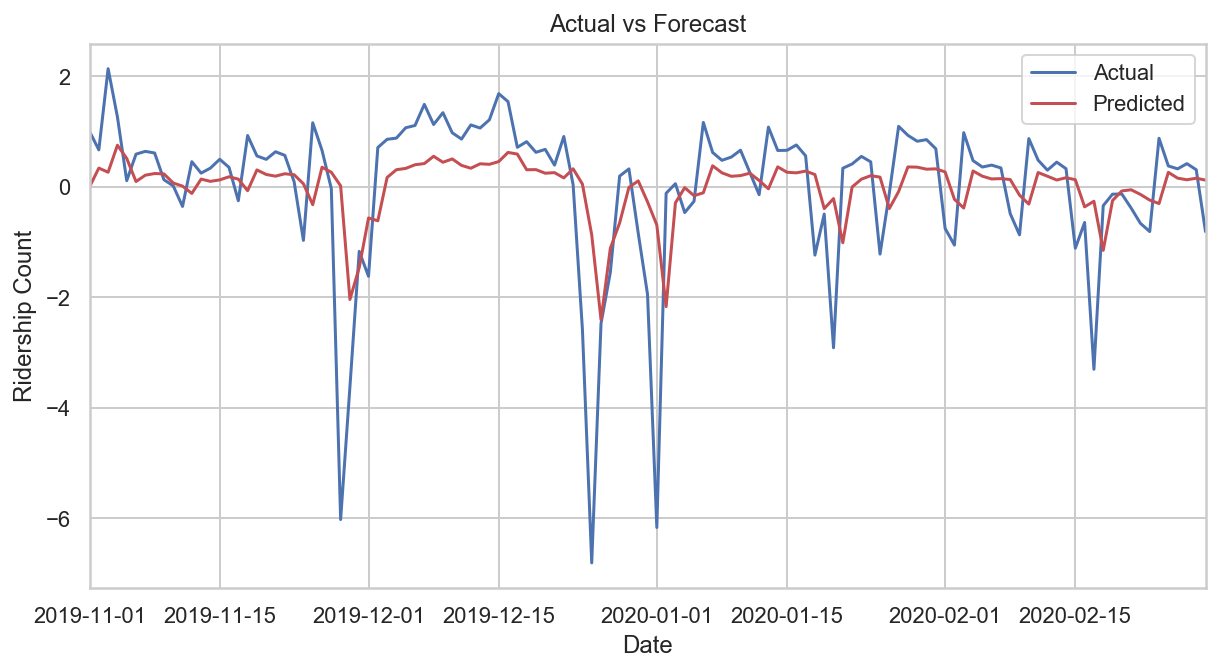

In [605]:
plot_forecast(df_preCovid_residual_test['residual_scaled'], df_preCovid_residual_test['pred'])
mse(df_preCovid_residual_test['residual_scaled'], df_preCovid_residual_test['pred'])

### Post-Covid MSE

In [615]:
df_postCovid.set_index('date', inplace=True)

In [616]:
df_postCovid['entries']

date
2020-03-01    2316878.0
2020-03-02    5064783.0
2020-03-03    5250286.0
2020-03-04    5291673.0
2020-03-05    5310236.0
                ...    
2020-06-26    1131249.0
2020-06-27     657579.0
2020-06-28     560713.0
2020-06-29    1127219.0
2020-06-30    1154557.0
Name: entries, Length: 122, dtype: float64

In [630]:
decomposition = seasonal_decompose(df_postCovid['entries_scaled'])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

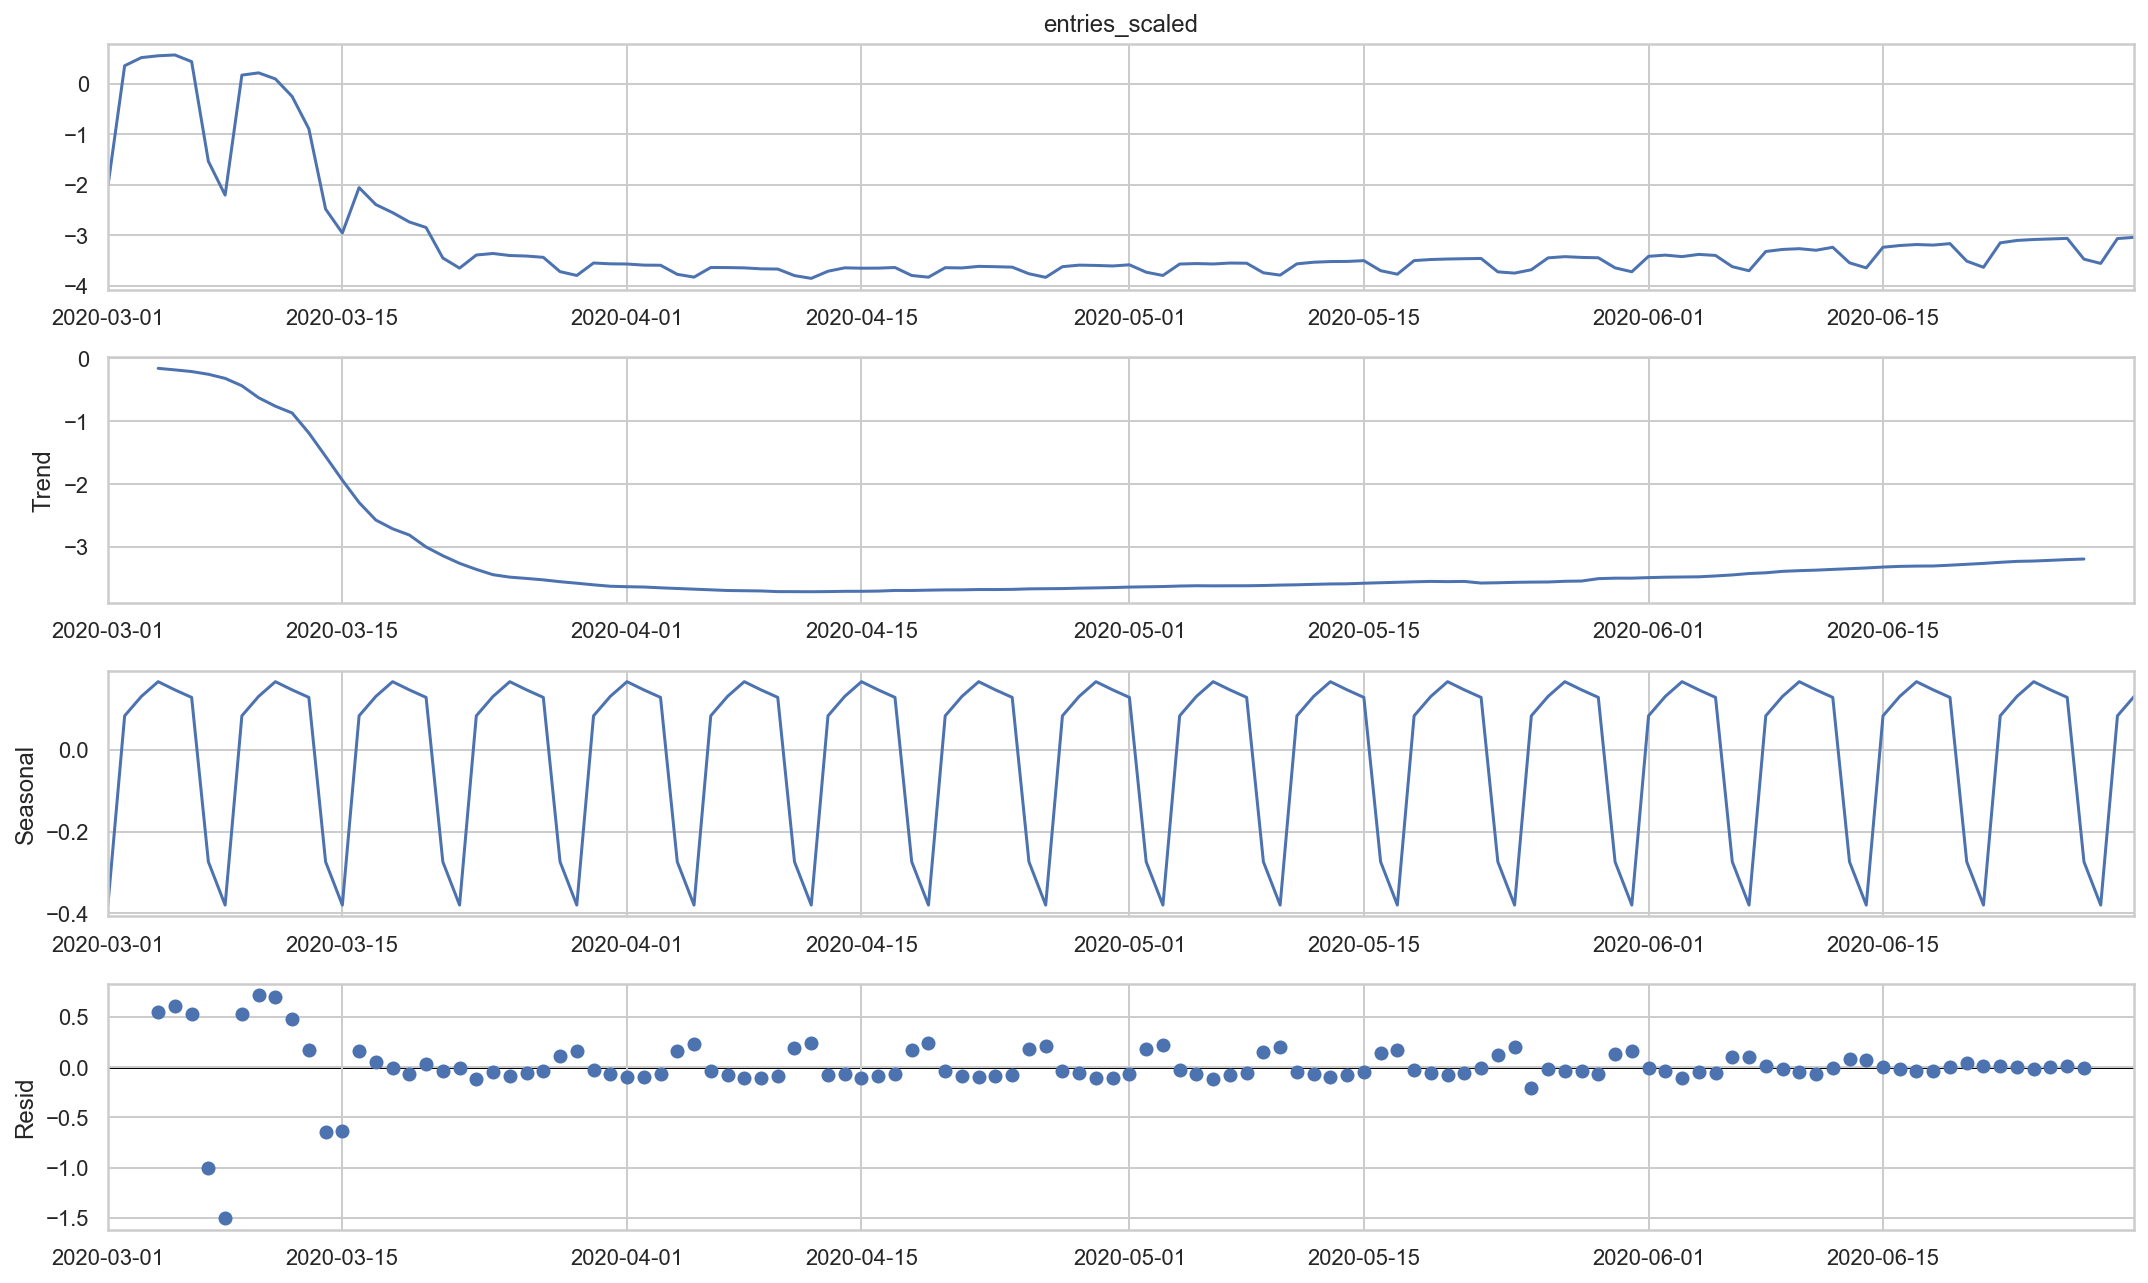

In [631]:
rcParams['figure.figsize'] = 15, 9
decomposition.plot()
plt.show()

In [632]:
df_postCovid_residual['pred'] = arma.forecast(residual)[:,0]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

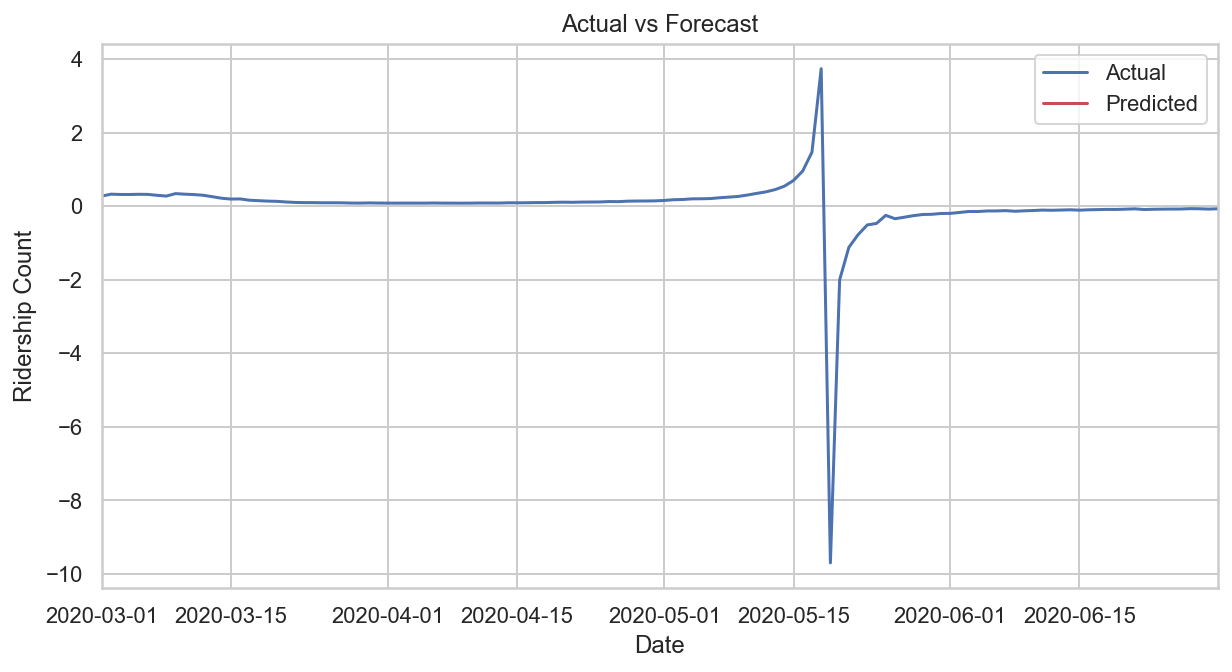

In [633]:
plot_forecast(df_postCovid_residual['residual_scaled'], df_postCovid_residual['pred'])
mse(df_postCovid_residual['residual_scaled'], df_postCovid_residual['pred'])

In [515]:
# df_postCovid_mod = df_postCovid.rename(columns={"entries": "entries_detrended"})
# df_postCovid_mod.head(2)

In [519]:
df_postCovid_train = df_postCovid[df_postCovid.date < '2020-06-01']
df_postCovid_test = df_postCovid[~(df_postCovid.date < '2020-06-01')]

92 92 122
              entries  entries_scaled  timediff  year  month  day  weekday  \
date                                                                         
2020-03-01  2316878.0       -2.031352       1.0  2020      3    1        6   
2020-03-02  5064783.0        0.359051       1.0  2020      3    2        0   

            timeindex         trend  
date                                 
2020-03-01     1884.0  2.660248e+06  
2020-03-02     1885.0  2.626460e+06  


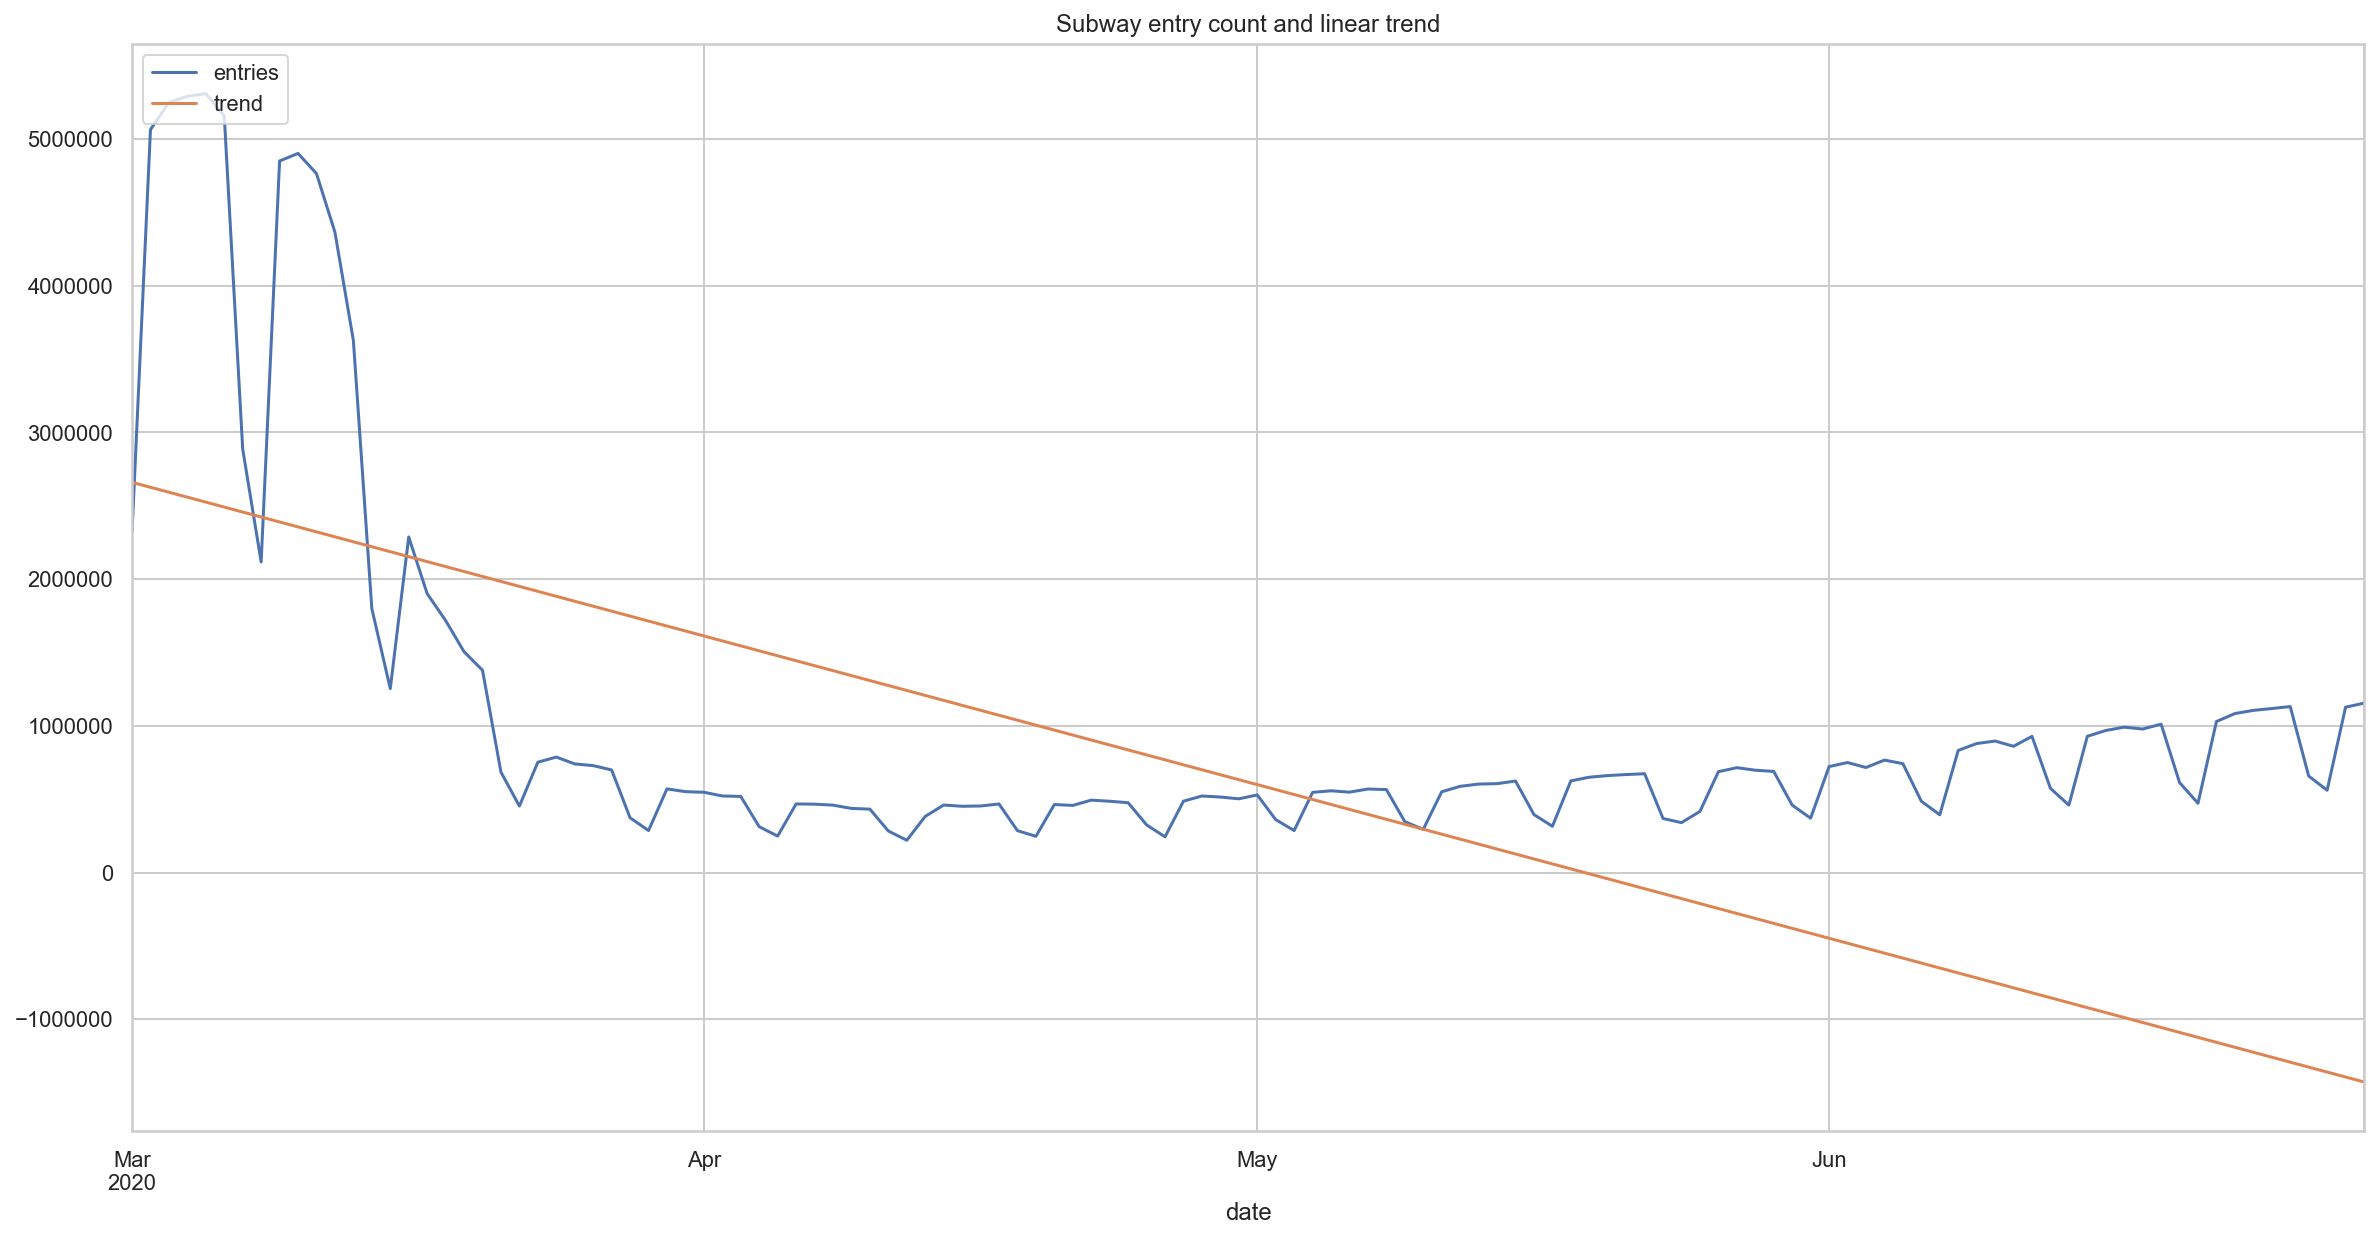

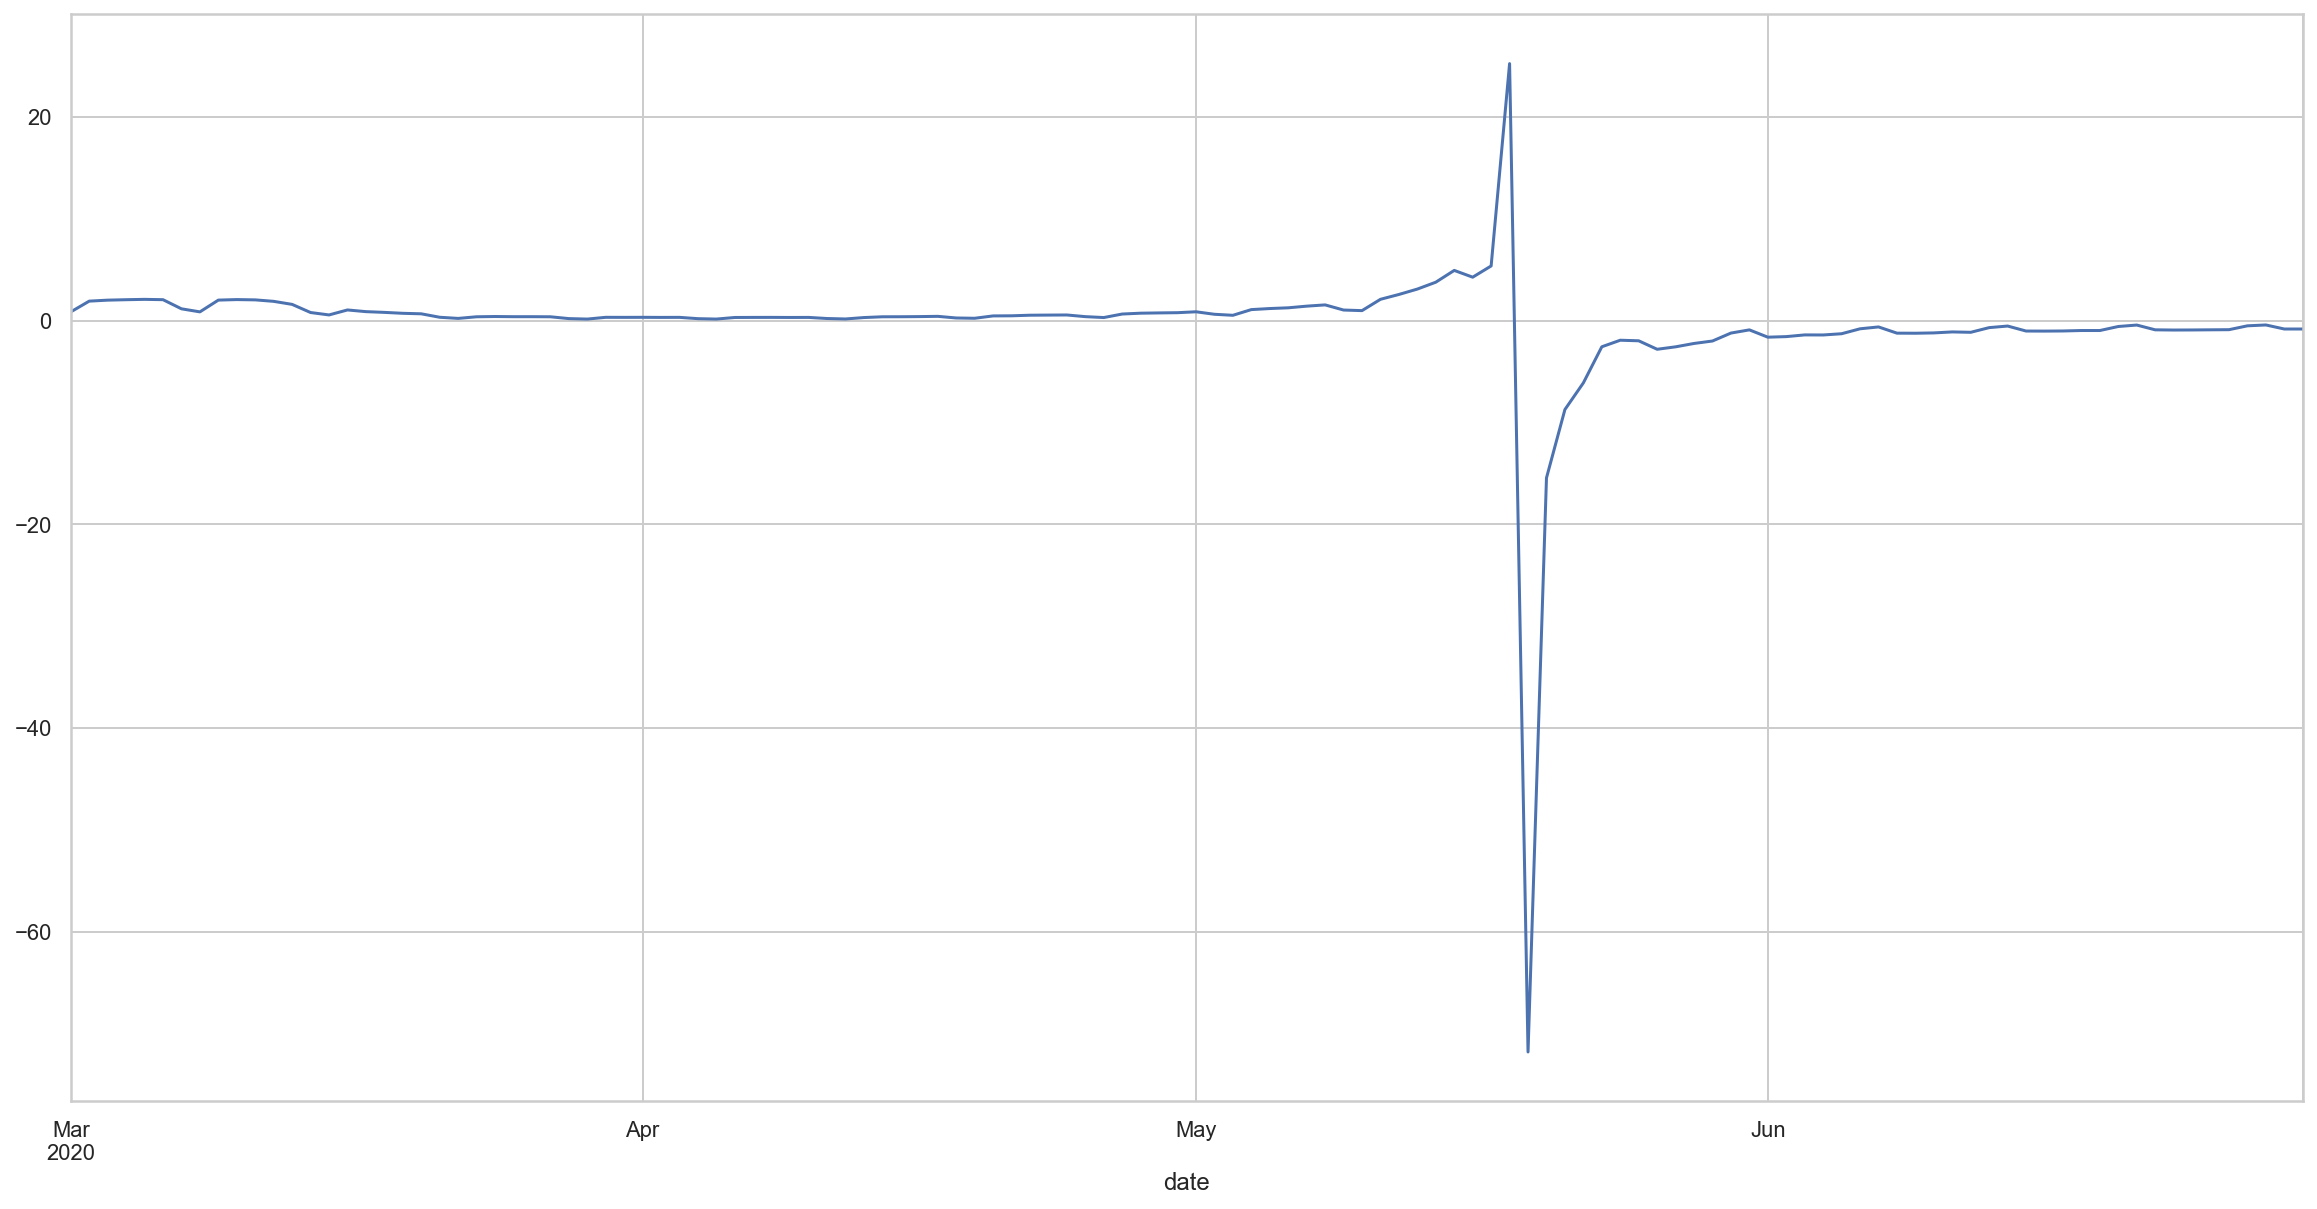

In [520]:
df_postCovid_mod = remove_lin_trend(df_postCovid_train, df_postCovid_test, df_postCovid)

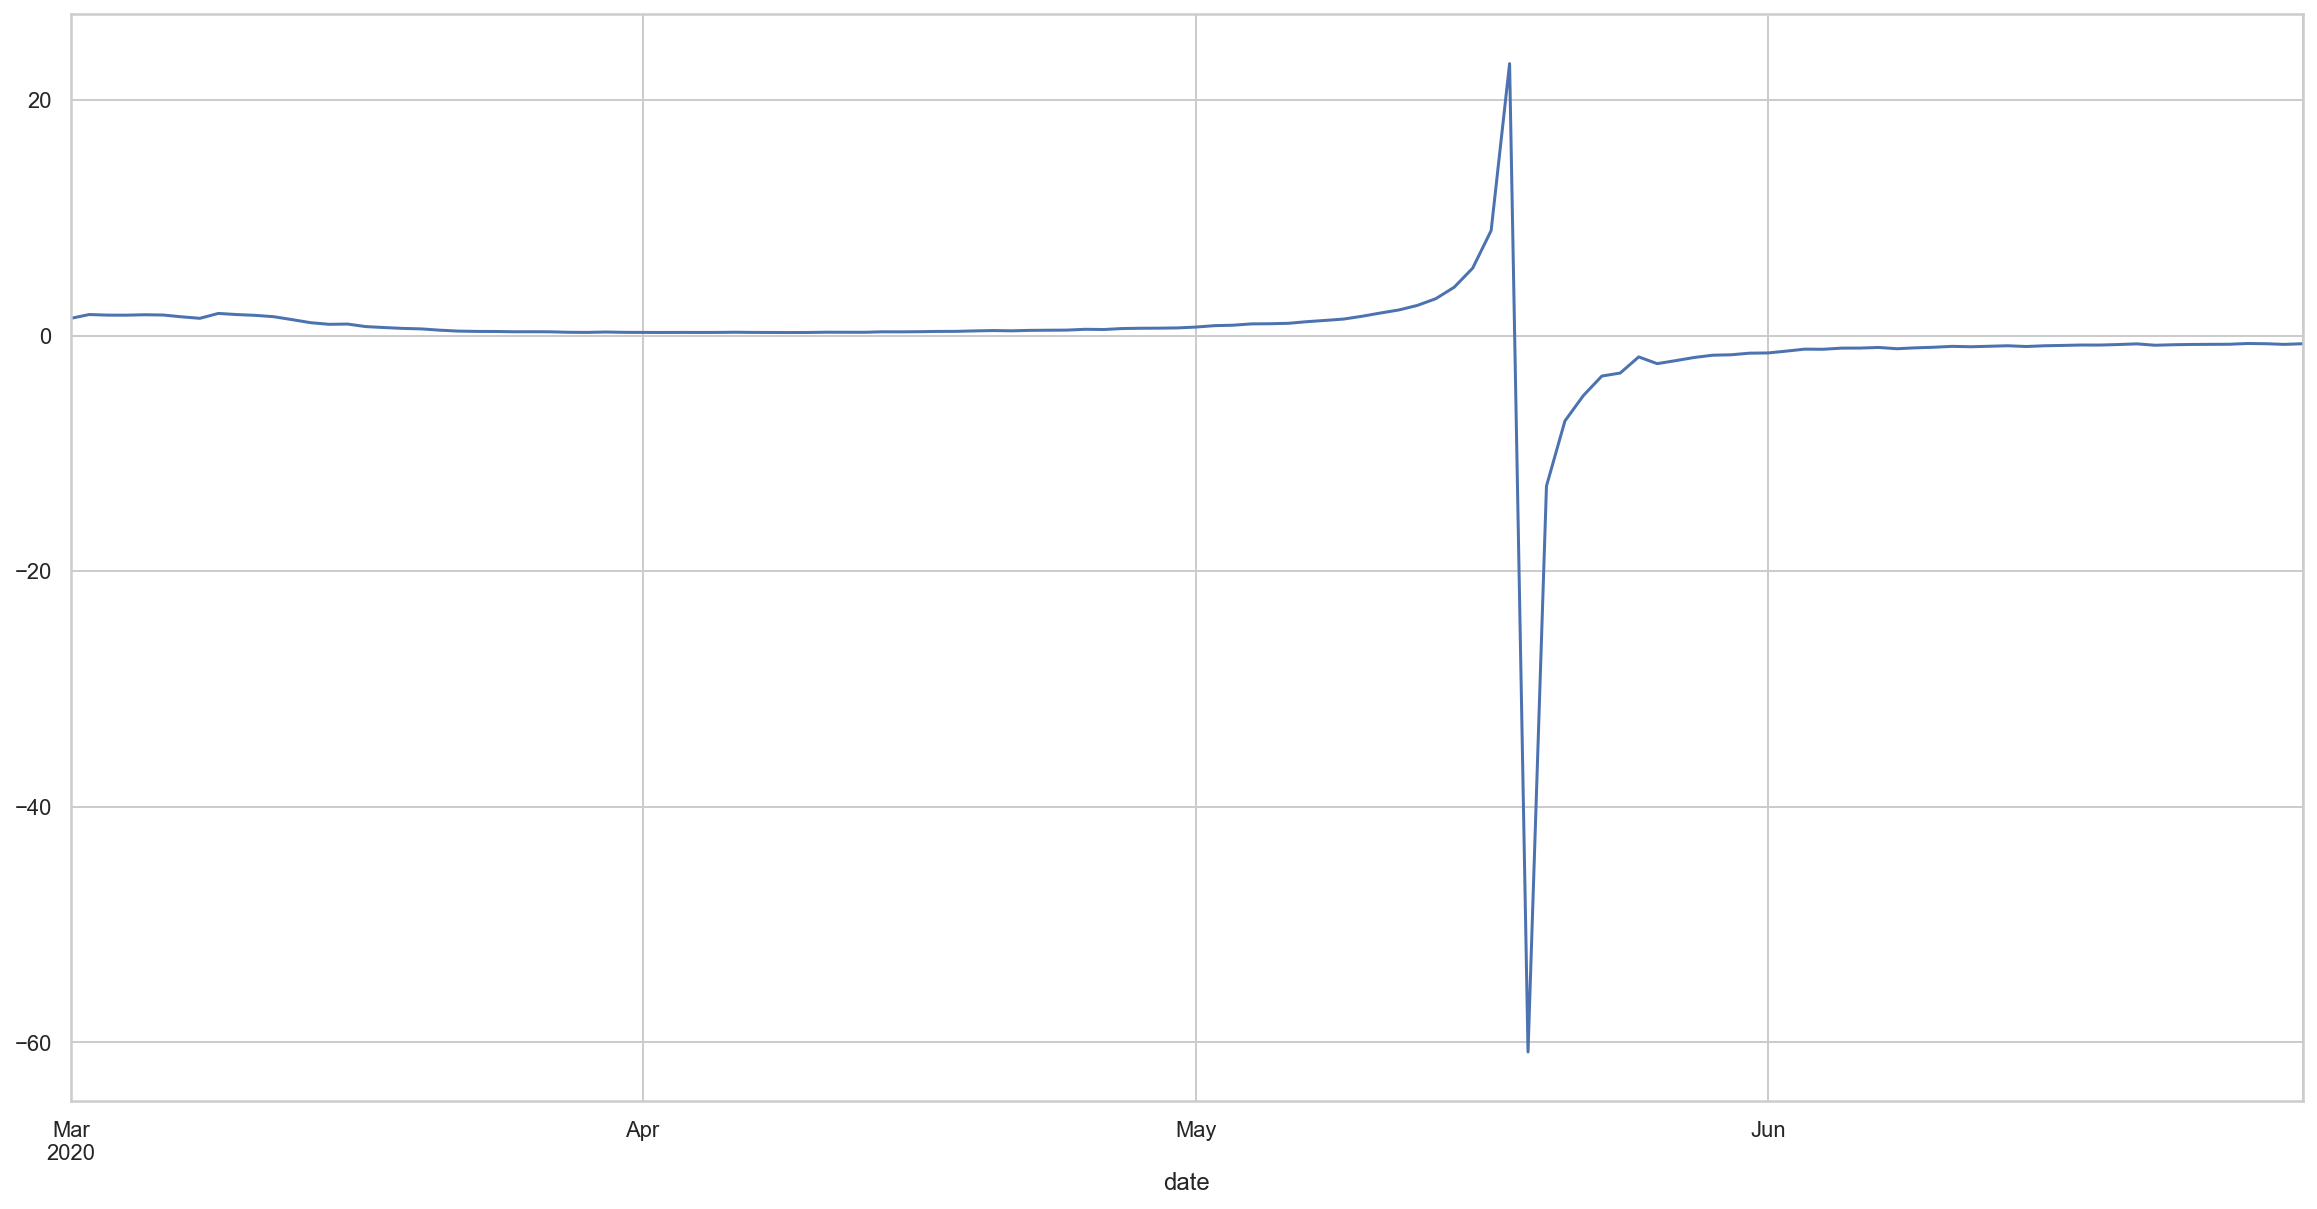

,entries,entries_scaled,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed
date,,,,,,,,,,,,
2020-03-01,2316878.0,-2.031352,1.0,2020,3,1,6,1884.0,2.660248e+06,0.870926,1.496021,1.473126
2020-03-02,5064783.0,0.359051,1.0,2020,3,2,0,1885.0,2.626460e+06,1.928369,1.827431,1.799464


In [521]:
df_postCovid_all = plot_factor_model(df_postCovid_mod)
df_postCovid_all.head(2)

In [523]:
df_postCovid_residual = df_postCovid_all[['entries_detrended_deweekdayed_demonthed']]

In [524]:
#standardize residual
scaler = StandardScaler()
scaler.fit(df_postCovid_residual)
print(scaler.mean_)
df_postCovid_residual['residual_scaled'] = scaler.transform(df_postCovid_residual)

[-0.21702567]


In [525]:
postCovid_residual= df_postCovid_residual['residual_scaled']
df_postCovid_residual['pred'] = arma.forecast(postCovid_residual)[:,0]

MSE: 1.1227


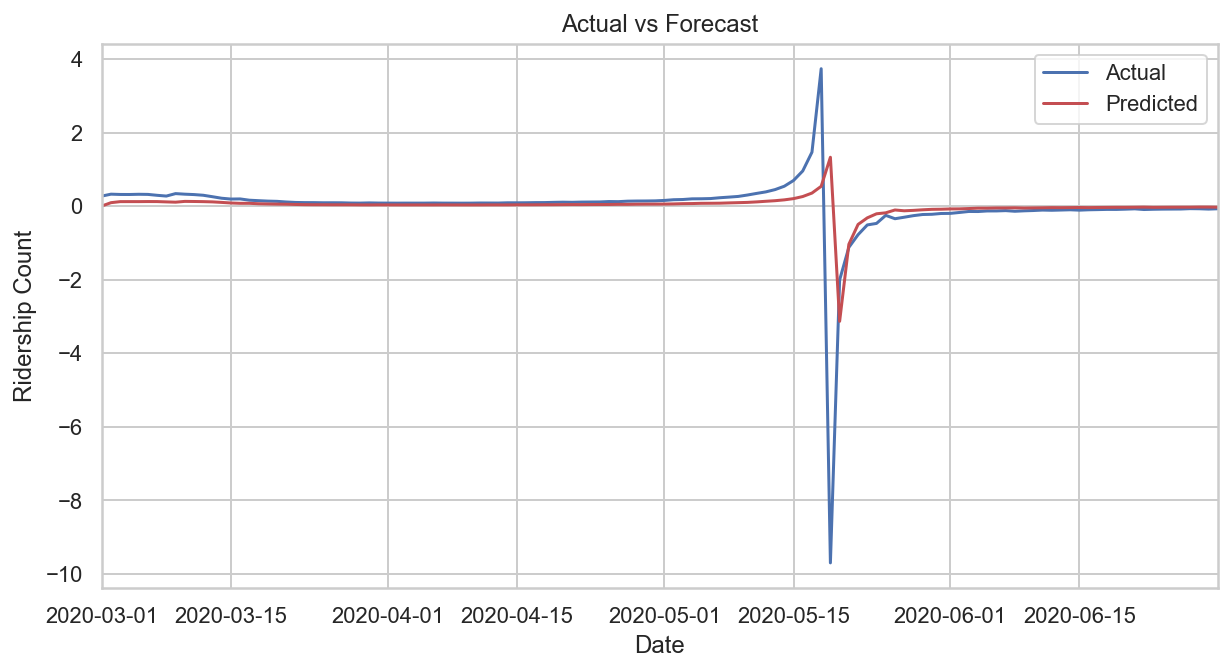

In [526]:
plot_forecast(df_postCovid_residual['residual_scaled'], df_postCovid_residual['pred'])
mse(df_postCovid_residual['residual_scaled'], df_postCovid_residual['pred'])

### Plot acf and pacf of new residual

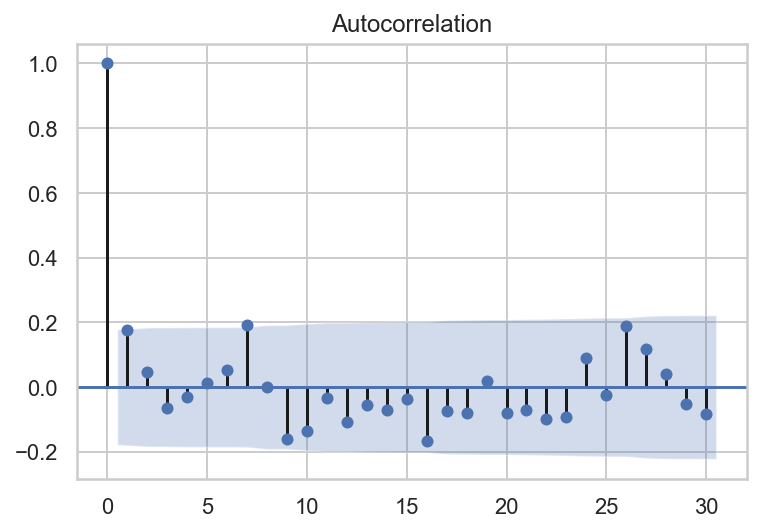

In [474]:
plot_acf((df_preCovid_residual_test['pred'] - df_preCovid_residual_test['residual_scaled']), lags=30)
plt.show()

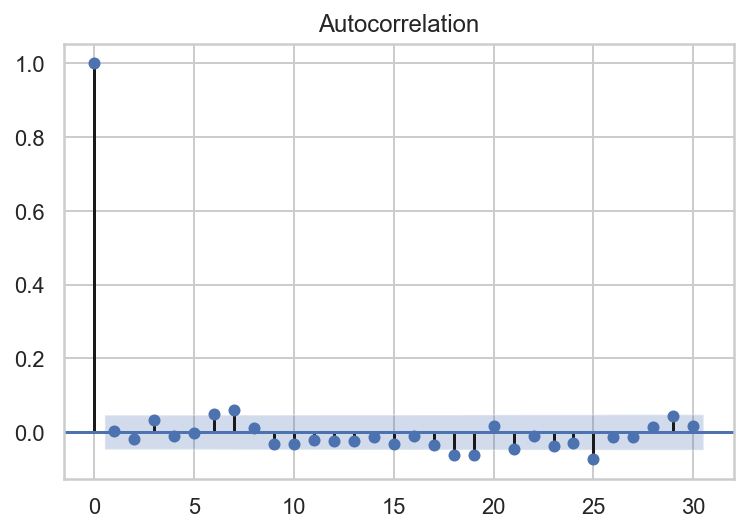

In [475]:
plot_acf((df_preCovid_residual_train['pred'] - df_preCovid_residual_train['residual_scaled']), lags=30)
plt.show()

### no correlation so results are gooood!

## SARIMAX

In [157]:
# Dataset
df_preCovid_train['lnEntries'] = np.log(df_preCovid_train['entries_diff'])

In [159]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(df_preCovid_train['lnEntries'] , order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                   D.DS12.lnEntries   No. Observations:                 1446
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -756.643
Date:                            Sun, 22 Nov 2020   AIC                           1521.285
Time:                                    21:29:50   BIC                           1542.392
Sample:                                01-16-2015   HQIC                          1529.163
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1397      0.039      3.618      0.000       0.064       0.215
ar.L2         -0.3361      0.027   